In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import torch
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import seaborn as sns
import os
import sys
import pickle
from glob import glob

# from gryffin import Gryffin
from atlas.optimizers.gp.planner import GPPlanner

from olympus.objects import ParameterContinuous, ParameterCategorical, ParameterVector
from olympus.campaigns import ParameterSpace, Campaign

sys.path.append('../../benchmarks_unknown/')
from benchmark_functions import DejongConstr, AckleyPathConstr, BraninConstr, HyperEllipsoidConstr, LevyConstr
from benchmark_functions import CatDejongConstr

sns.set(style='ticks', context='notebook', font_scale=1.2)

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])
plt.register_cmap(cmap=_cmap)
plt.register_cmap(cmap=_cmap_r)

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%d', n_contour_lines=5, contour_color='k', contour_alpha=1, cbar=False, cmap='golem'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_constr_surface(surface, ax=None, N=100, constr=True, plot_min=True, contour=True, cmap='golem', alpha=1.,contour_alpha=1.):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    if contour:
        _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=alpha, contour_lines=True, contour_labels=True, 
                     labels_fs=12, labels_fmt='%d', n_contour_lines=5, contour_alpha=contour_alpha, cbar=False, cmap=cmap)
       
        if plot_min:
            for param in surface.minima:
                x_min = param['params']
                ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ec90c8', zorder=20)
    
    if constr:
        y_feas = np.array(surface.eval_constr(X))
        Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
        ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        
def plot_binary_surface(ax, Y, threshold=0.5):

    Y_binary = np.where(Y > threshold, 1.0, Y)  # if Y>0.5 return 1.0 else Y
    Y_binary = np.where(Y_binary <= threshold, 0.0, Y_binary)

    _ = plot_contour(ax, X0, X1, Y_binary, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=False, 
                 labels_fs=12, labels_fmt='%.2f', n_contour_lines=0, contour_alpha=1, cbar=False, cmap='RdBu')


In [4]:
from olympus.surfaces import (
        Dejong, StyblinskiTang, Kilimanjaro,
        Schwefel, Levy, 
)

from benchmark_functions import Constr

Surf = Dejong

class DummySurface1(Dejong, Constr):
    def is_feasible(self, Xi):
        x0 = Xi[0]
        x1 = Xi[1]
        if x0 + x1 > 1.0:
            return False
        else:
            return True
        
        
class DummySurface2(Surf, Constr):
    def is_feasible(self, Xi):
        x0 = Xi[0]
        x1 = Xi[1]
        
        if x0**2 + (x1-1)**2 < 0.25:
            return False
        if (x0-1)**2 + x1**2 < 0.25:
            return False
        return True
    
    
class DummySurface3(Surf, Constr):
    def is_feasible(self, Xi):
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        if np.sum(np.sqrt(np.abs(Xi-0.5))) < 0.70:
            return False
        return True
    

class DummySurface4(Surf, Constr):
    def is_feasible(self, Xi):
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        centers = [[0.25, 0.25],[0.25, 0.75],[0.5, 0.5], [0.75, 0.25],[0.75, 0.75]]
        
        for center in centers:
            if (x0 - center[0])**2 + (x1 - center[1])**2 < 0.015:
                return False
        return True

## Figure 1 concept

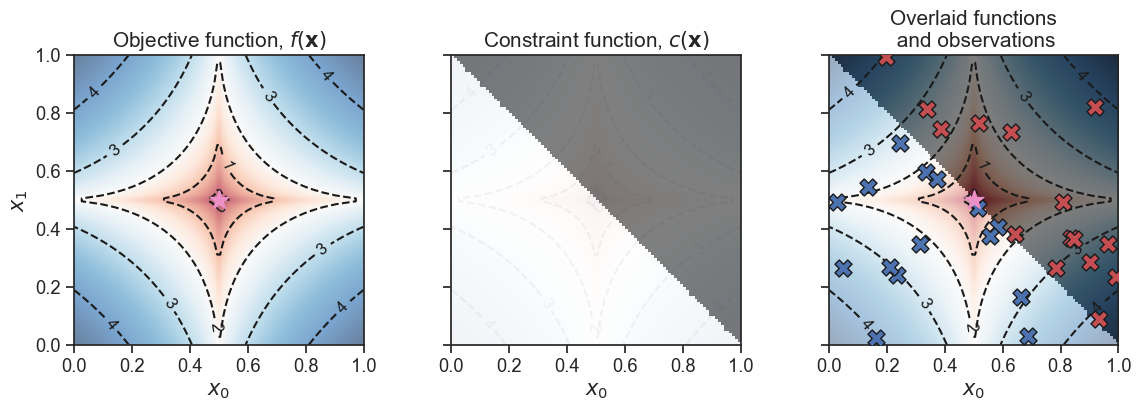

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
axes = axes.flatten()

cmap='RdBu'

# generate data
surface = DummySurface1()
n = 30

# random sampling
np.random.seed(30)
X = np.random.uniform(low=0, high=1, size=(n, 2))
obj = np.array(surface.run_constr(X)).flatten()

mask = np.isnan(obj)
X_feas = X[~mask]
X_infs = X[mask]

# build olympus parameter space for 2d continuous example
# param_space = ParameterSpace()
# param_space.add(ParameterContinuous(name='param0'))
# param_space.add(ParameterContinuous(name='param1'))

# # build the campaign
# campaign = Campaign()
# campaign.set_param_space(param_space)

# # add the observations to the campaign
# for x, y in zip(X, obj):
#     campaign.add_observation(x, y)
    
# # build the atlas planner
# planner = GPPlanner(
#         goal='minimize',
#         feas_strategy='fwa',
#         acquisition_type='ei',#'ucb',
#         feas_param=0.,
#         vgp_iters=2000,
#         vgp_lr=0.01
# )
# planner.set_param_space(param_space)

# _ = planner.recommend(campaign.observations)


# # build the test input 
# res = 50
# x0 = np.linspace(0,1,res)
# x1 = np.linspace(0,1,res)
# X0,X1 = np.meshgrid(x0,x1)

# inp = np.vstack([X0.ravel(),X1.ravel()]).T
# inp_torch = torch.tensor(inp)
    

# # PREDICTIONS OF REGRESSION SURROGATE
# pred_mean, pred_sigma = planner.reg_surrogate(inp_torch, return_np=True)
# pred_mean_Y = pred_mean.reshape(X0.shape) # for plotting

# # PREDICTIONS OF FEASIBILITY SURROGATE
# pred_feas = 1. - planner.cla_surrogate(inp_torch, return_np=True)
# pred_feas_Y = pred_feas.reshape(X0.shape) # for plotting

# # FEASIBILITY AWARE ACQUISITION
# pred_acqf = planner.acquisition_function(inp_torch, return_np=True)
# pred_acqf_Y = pred_acqf.reshape(X0.shape) # for plotting
    
    
# binary constraint stuff
y_constr = np.array(surface.eval_constr(inp))
Y_constr = np.reshape(y_constr, newshape=np.shape(X0))


# objective function
plot_constr_surface(surface, ax=axes[0], N=100, constr=False, cmap=cmap, alpha=0.6)

# constraint function
plot_constr_surface(
    surface, ax=axes[1], N=100, constr=True, contour=True, plot_min=False, cmap=cmap, alpha=0.1, contour_alpha=0.05,
)

# overlaid function with observations plotted
plot_constr_surface(surface, ax=axes[2], N=100, constr=True, contour=True, cmap=cmap, alpha=0.8)
axes[2].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=150, color='b', edgecolor='k', zorder=10)
axes[2].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=150, color='r', edgecolor='k', zorder=10)


axes[0].set_ylabel(r'$x_1$',fontsize=15)
for ix in [0, 1, 2]:
    axes[ix].set_xlabel(r'$x_0$',fontsize=15)
    
# tick_labels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# for ax in axes:
#     ax.set_xticklabels(tick_labels, fontsize=12)
#     ax.set_yticklabels(tick_labels, fontsize=12)



axes[0].set_title(r'Objective function, $f(\mathbf{x})$',fontsize=15)
axes[1].set_title(r'Constraint function, $c(\mathbf{x})$',fontsize=15)
axes[2].set_title(f'Overlaid functions\n and observations',fontsize=15)

plt.tight_layout()
plt.savefig('conceptual_constraints.png', dpi=300)

## 4x7 figure with depictions of feas-aware acqfs on. analytic surfaces

In [5]:
### CONCEPTUAL FIGURE FOR PAPER


# fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
# axes = axes.flatten()

cmap='RdBu'

# generate observations
n = 30
# random sampling
np.random.seed(30)
X = np.random.uniform(low=0, high=1, size=(n, 2))


surfaces = []
#----------
# Surface 1 
#----------
surface1 = DummySurface1()
obj1 = np.array(surface1.run_constr(X)).flatten()
mask1 = np.isnan(obj1)
X_feas1 = X[~mask1]
X_infs1 = X[mask1]
surfaces.append({'name':'surface1', 'object': surface1, 'obj': obj1, 'mask': mask1, 'X_feas': X_feas1, 'X_infs': X_infs1})

#----------
# Surface 2 
#----------
surface2 = DummySurface2()
obj2 = np.array(surface2.run_constr(X)).flatten()
mask2 = np.isnan(obj2)
X_feas2 = X[~mask2]
X_infs2 = X[mask2]
surfaces.append({'name':'surface2', 'object': surface2, 'obj': obj2, 'mask': mask2, 'X_feas': X_feas2, 'X_infs': X_infs2})


#----------
# Surface 3
#----------
surface3 = DummySurface3()
obj3 = np.array(surface3.run_constr(X)).flatten()
mask3 = np.isnan(obj3)
X_feas3 = X[~mask3]
X_infs3 = X[mask3]
surfaces.append({'name':'surface3', 'object': surface3, 'obj': obj3, 'mask': mask3, 'X_feas': X_feas3, 'X_infs': X_infs3})


#----------
# Surface 4
#----------
surface4 = DummySurface4()
obj4 = np.array(surface4.run_constr(X)).flatten()
mask4 = np.isnan(obj4)
X_feas4 = X[~mask4]
X_infs4 = X[mask4]
surfaces.append({'name':'surface4', 'object': surface4, 'obj': obj4, 'mask': mask4, 'X_feas': X_feas4, 'X_infs': X_infs4})



# generate surrogate models for all combinations
campaigns_dict =  {}
for surface_ix, surface in enumerate(surfaces):
    for feas_strategy in ['fwa', 'fca', 'fia']:
        
        print(f'\n\n GENERATING DATA FOR {surface["name"]}-{feas_strategy}...\n')
        
        # build olympus parameter space for 2d continuous example
        param_space = ParameterSpace()
        param_space.add(ParameterContinuous(name='param0'))
        param_space.add(ParameterContinuous(name='param1'))

        # build the campaign
        campaign = Campaign()
        campaign.set_param_space(param_space)

        # add the observations to the campaign
        for x, y in zip(X, surface['obj']):
            campaign.add_observation(x, y)

        if feas_strategy == 'fwa':
            feas_param=0.0
        elif feas_strategy == 'fca': 
            feas_param = 0.5
        elif feas_strategy == 'fia':
            feas_param = 1.
            
        # build the atlas planner
        planner = GPPlanner(
                goal='minimize',
                feas_strategy=feas_strategy,
                acquisition_type='ei',#'ucb',
                feas_param=feas_param,
                vgp_iters=2000,
                vgp_lr=0.01
        )
        planner.set_param_space(param_space)
        
        _ = planner.recommend(campaign.observations)

        # build the test input 
        res = 50
        x0 = np.linspace(0,1,res)
        x1 = np.linspace(0,1,res)
        X0,X1 = np.meshgrid(x0,x1)

        inp = np.vstack([X0.ravel(),X1.ravel()]).T
        inp_torch = torch.tensor(inp)

        # PREDICTIONS OF REGRESSION SURROGATE
        pred_mean, pred_sigma = planner.reg_surrogate(inp_torch, return_np=True)
        pred_mean_Y = pred_mean.reshape(X0.shape) # for plotting

        # PREDICTIONS OF FEASIBILITY SURROGATE
        pred_feas = 1. - planner.cla_surrogate(inp_torch, return_np=True)
        pred_feas_Y = pred_feas.reshape(X0.shape) # for plotting

        # FEASIBILITY AWARE ACQUISITION
        pred_acqf = planner.acquisition_function(inp_torch, return_np=True)
        pred_acqf_Y = pred_acqf.reshape(X0.shape) # for plotting
        
        # FEASIBILITY UNAWARE ACQUISITION
        pred_acqf_unconst = planner.acquisition_function(inp_torch, return_np=True, unconstrained=True)
        pred_acqf_unconst_Y = pred_acqf_unconst.reshape(X0.shape) # for plotting


        # binary constraint stuff
        y_constr = np.array(surface['object'].eval_constr(inp))
        Y_constr = np.reshape(y_constr, newshape=np.shape(X0))
        
        campaigns_dict[f'{surface["name"]}-{feas_strategy}'] = {
            'X0': X0, 'X1': X1, 
            'pred_mean': pred_mean, 'pred_mean_Y': pred_mean_Y, 
            'pred_feas': pred_feas, 'pred_feas_Y': pred_feas_Y,
            'pred_acqf': pred_acqf, 'pred_acqf_Y': pred_acqf_Y,
            'pred_acqf_unconst': pred_acqf_unconst, 'pred_acqf_unconst_Y': pred_acqf_unconst_Y,
            'y_constr': y_constr, 'Y_constr': Y_constr,
        }

        




 GENERATING DATA FOR surface1-fwa...



[INFO] Regression surrogate GP trained in 0.096 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 5.308 sec (1836 epochs)  Loss : 0.313

[INFO]  Classification surrogate VGP trained in 5.748 sec (1999 epochs)  Loss : 0.35

[INFO]  Classification surrogate VGP trained in 5.732 sec (1999 epochs)  Loss : 0.361

[INFO]  Classification surrogate VGP trained in 9.368 sec (1944 epochs)  Loss : 0.364



 GENERATING DATA FOR surface1-fca...



/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)


[INFO] Regression surrogate GP trained in 0.061 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 5.736 sec (1999 epochs)  Loss : 0.348

[INFO]  Classification surrogate VGP trained in 5.741 sec (1999 epochs)  Loss : 0.336

[INFO]  Classification surrogate VGP trained in 5.722 sec (1999 epochs)  Loss : 0.356

[INFO]  Classification surrogate VGP trained in 9.315 sec (1999 epochs)  Loss : 0.363



 GENERATING DATA FOR surface1-fia...



[INFO] Regression surrogate GP trained in 0.059 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 5.793 sec (1999 epochs)  Loss : 0.353

[INFO]  Classification surrogate VGP trained in 5.663 sec (1999 epochs)  Loss : 0.364

[INFO]  Classification surrogate VGP trained in 1.678 sec (595 epochs)   Loss : 0.351

[INFO]  Classification surrogate VGP trained in 4.387 sec (1531 epochs)  Loss : 0.37



 GENERATING DATA FOR surface2-fwa...



/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)


[INFO] Regression surrogate GP trained in 0.054 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 1.139 sec (404 epochs)   Loss : 0.463

[INFO]  Classification surrogate VGP trained in 1.84 sec (655 epochs)    Loss : 0.466

[INFO]  Classification surrogate VGP trained in 1.284 sec (456 epochs)   Loss : 0.457

[INFO]  Classification surrogate VGP trained in 2.193 sec (505 epochs)   Loss : 0.484



 GENERATING DATA FOR surface2-fca...



/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)


[INFO] Regression surrogate GP trained in 0.056 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 1.961 sec (674 epochs)   Loss : 0.458

[INFO]  Classification surrogate VGP trained in 1.458 sec (503 epochs)   Loss : 0.434

[INFO]  Classification surrogate VGP trained in 1.603 sec (554 epochs)   Loss : 0.481

[INFO]  Classification surrogate VGP trained in 2.646 sec (577 epochs)   Loss : 0.479



 GENERATING DATA FOR surface2-fia...



/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8.'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), RuntimeWarning('Values in x were outside bounds during a minimize step, clipping to bounds'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), RuntimeWarning('Values in x were outside bounds during a minimize step, cl

[INFO] Regression surrogate GP trained in 0.054 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 1.255 sec (447 epochs)   Loss : 0.456

[INFO]  Classification surrogate VGP trained in 2.043 sec (695 epochs)   Loss : 0.465

[INFO]  Classification surrogate VGP trained in 1.214 sec (433 epochs)   Loss : 0.445

[INFO]  Classification surrogate VGP trained in 2.152 sec (525 epochs)   Loss : 0.49



 GENERATING DATA FOR surface3-fwa...



[INFO] Regression surrogate GP trained in 0.154 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 1.892 sec (621 epochs)   Loss : 0.479

[INFO]  Classification surrogate VGP trained in 1.628 sec (540 epochs)   Loss : 0.437

[INFO]  Classification surrogate VGP trained in 1.694 sec (545 epochs)   Loss : 0.419

[INFO]  Classification surrogate VGP trained in 2.712 sec (568 epochs)   Loss : 0.461

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)




 GENERATING DATA FOR surface3-fca...



[INFO] Regression surrogate GP trained in 0.149 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 1.464 sec (487 epochs)   Loss : 0.448

[INFO]  Classification surrogate VGP trained in 1.88 sec (629 epochs)    Loss : 0.482

[INFO]  Classification surrogate VGP trained in 1.21 sec (400 epochs)    Loss : 0.428

[INFO]  Classification surrogate VGP trained in 2.112 sec (505 epochs)   Loss : 0.465



 GENERATING DATA FOR surface3-fia...



[INFO] Regression surrogate GP trained in 0.154 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 1.417 sec (467 epochs)   Loss : 0.406

[INFO]  Classification surrogate VGP trained in 2.109 sec (703 epochs)   Loss : 0.471

[INFO]  Classification surrogate VGP trained in 2.428 sec (788 epochs)   Loss : 0.449

[INFO]  Classification surrogate VGP trained in 3.603 sec (652 epochs)   Loss : 0.46

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)




 GENERATING DATA FOR surface4-fwa...



[INFO] Regression surrogate GP trained in 0.08 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 1.591 sec (545 epochs)   Loss : 0.647

[INFO]  Classification surrogate VGP trained in 1.037 sec (360 epochs)   Loss : 0.599

[INFO]  Classification surrogate VGP trained in 1.186 sec (396 epochs)   Loss : 0.675

[INFO]  Classification surrogate VGP trained in 1.971 sec (433 epochs)   Loss : 0.581



 GENERATING DATA FOR surface4-fca...



/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)


[INFO] Regression surrogate GP trained in 0.08 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 1.065 sec (369 epochs)   Loss : 0.612

[INFO]  Classification surrogate VGP trained in 1.389 sec (470 epochs)   Loss : 0.608

[INFO]  Classification surrogate VGP trained in 2.371 sec (804 epochs)   Loss : 0.61

[INFO]  Classification surrogate VGP trained in 3.364 sec (547 epochs)   Loss : 0.58



 GENERATING DATA FOR surface4-fia...



[INFO] Regression surrogate GP trained in 0.079 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 1.253 sec (433 epochs)   Loss : 0.67

[INFO]  Classification surrogate VGP trained in 1.087 sec (374 epochs)   Loss : 0.625

[INFO]  Classification surrogate VGP trained in 1.101 sec (372 epochs)   Loss : 0.657

[INFO]  Classification surrogate VGP trained in 1.823 sec (393 epochs)   Loss : 0.583

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)


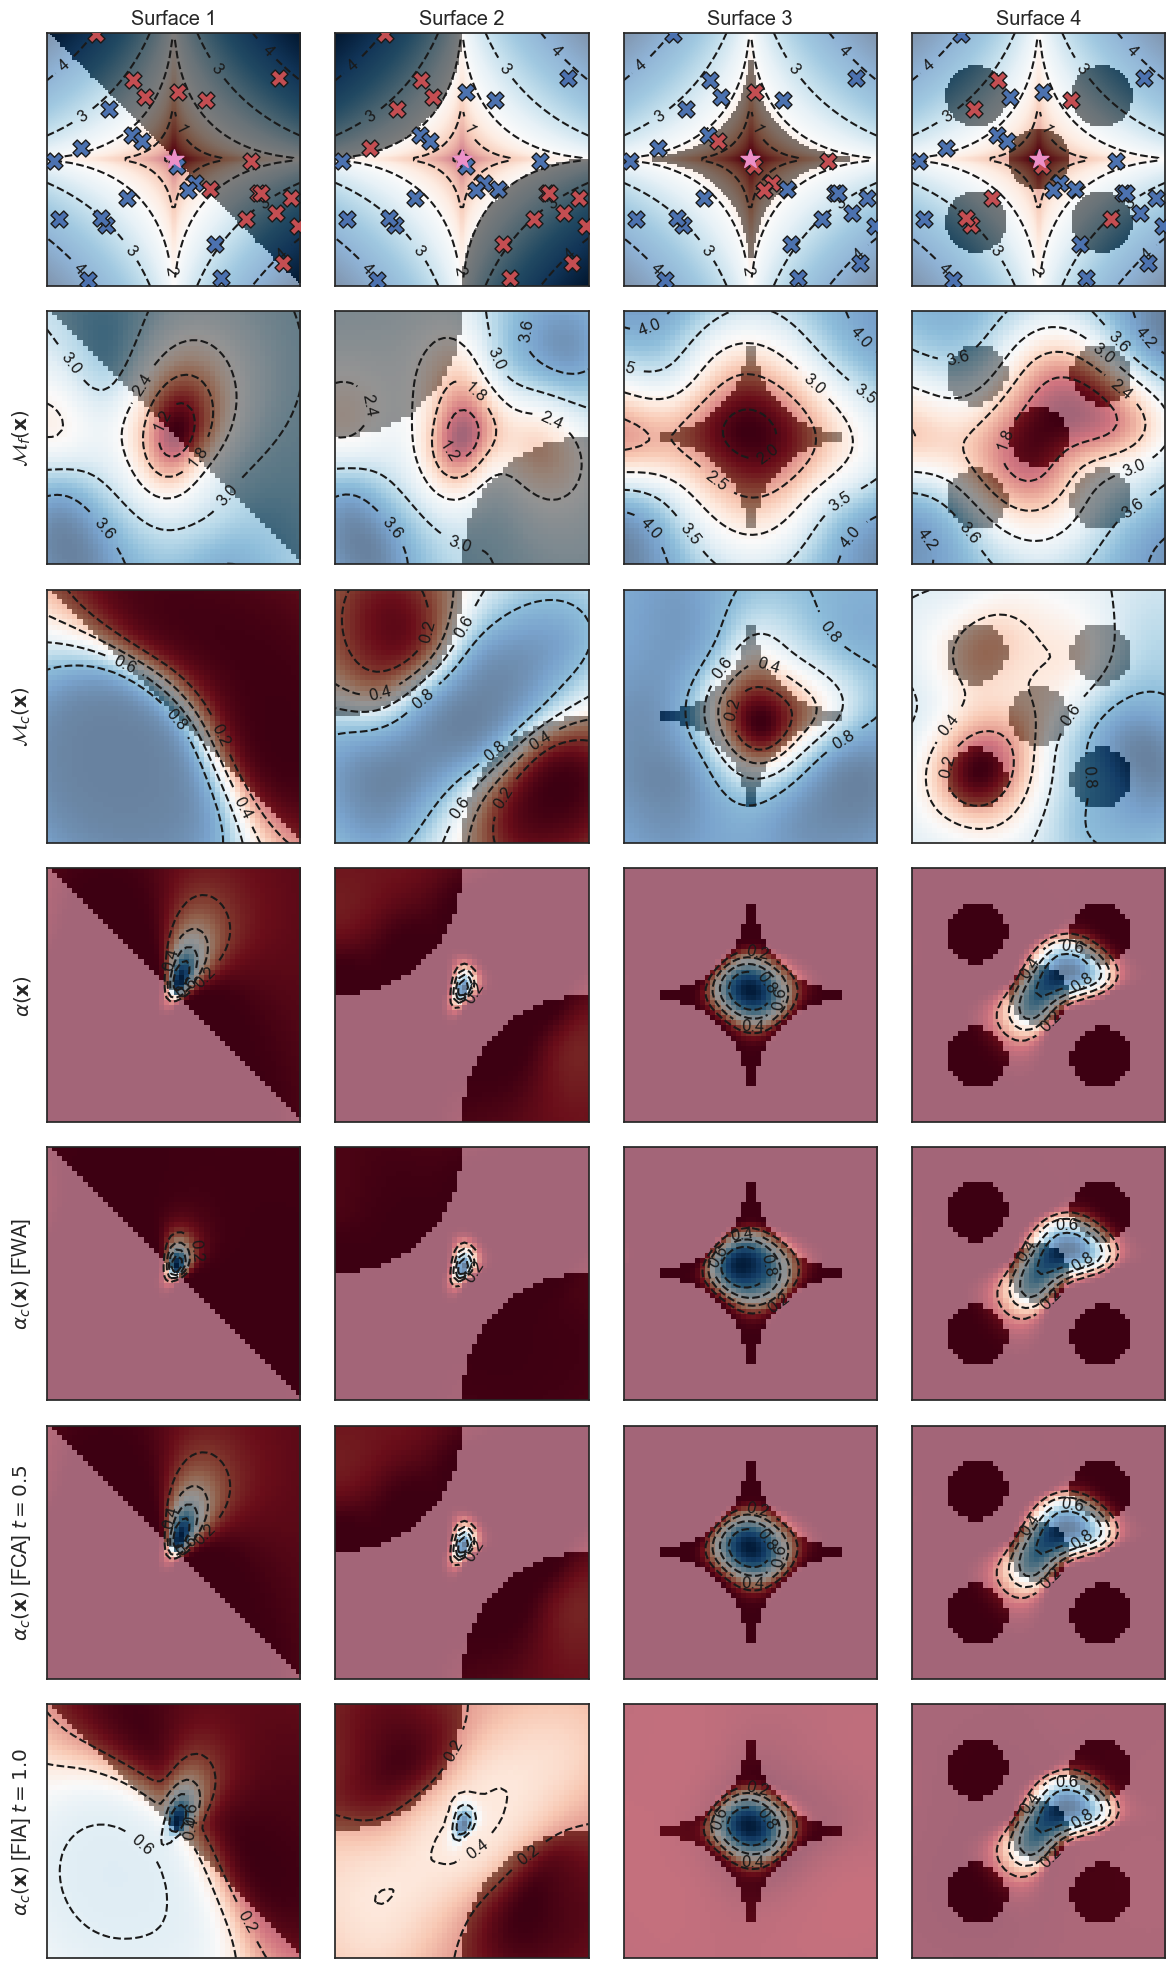

In [7]:
fig, axes = plt.subplots(7, 4, figsize=(12, 20), sharex=True, sharey=True)
# axes = axes.flatten()


for s_ix, surface in enumerate(surfaces):
    
    
    # overlaid function with observations plotted
    plot_constr_surface(surface['object'], ax=axes[0, s_ix], N=100, constr=True, contour=True, cmap=cmap)
    axes[0, s_ix].scatter(X[~surface['mask']].T[0], X[~surface['mask']].T[1], marker='X', s=150, color='b', edgecolor='k', zorder=10)
    axes[0, s_ix].scatter(X[surface['mask']].T[0], X[surface['mask']].T[1], marker='X', s=150, color='r', edgecolor='k', zorder=10)
    
    
    
    # regression prediction
    info = campaigns_dict[f'{surface["name"]}-fwa']
    im = plot_contour(
                axes[1,s_ix], info['X0'], info['X1'], info['pred_mean_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[1,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')


#     axes[1,s_ix].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
#     axes[1,s_ix].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)


    # cla surrogate
    im = plot_contour(
                axes[2,s_ix], info['X0'], info['X1'], info['pred_feas_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[2,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')

#     axes[2,s_ix].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
#     axes[2,s_ix].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)


    # feasibility-unaware acquisition function
    # alpha(x)
    info = campaigns_dict[f'{surface["name"]}-fwa']
    im = plot_contour(
                axes[3,s_ix], info['X0'], info['X1'], info['pred_acqf_unconst_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[3,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')

    

    # feasibility-aware acquisition function
    # FWA
    info = campaigns_dict[f'{surface["name"]}-fwa']
    im = plot_contour(
                axes[4,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[4,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')

    
    # feasibility-aware acquisition function
    # FCA
    info = campaigns_dict[f'{surface["name"]}-fca']
    im = plot_contour(
                axes[5,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[5,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')

    # feasibility-aware acquisition function
    # FIA
    info = campaigns_dict[f'{surface["name"]}-fia']
    im = plot_contour(
                axes[6,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[6,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')

    
for i in range(4):
    axes[0,i].set_title(f'Surface {i+1}')

axes[1,0].set_ylabel(r'$\mathcal{M}_f(\mathbf{x})$')
axes[2,0].set_ylabel(r'$\mathcal{M}_c(\mathbf{x})$')
axes[3,0].set_ylabel(r'$\alpha (\mathbf{x})$')
axes[4,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FWA]')
axes[5,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FCA] $t=0.5$')
axes[6,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FIA] $t=1.0$')


# tick_labels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
for ax in axes.flatten():
#     ax.set_xticklabels(tick_labels, fontsize=12)
#     ax.set_yticklabels(tick_labels, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

plt.subplots_adjust(
                    wspace=0.1,
                    hspace=0.1)

In [39]:
### CONCEPTUAL FIGURE FOR PAPER


# fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
# axes = axes.flatten()

cmap='RdBu'

# generate observations
n = 30
# random sampling
np.random.seed(30)
X = np.random.uniform(low=0, high=1, size=(n, 2))


surfaces = []
#----------
# Surface 1 
#----------
surface1 = DummySurface1()
obj1 = np.array(surface1.run_constr(X)).flatten()
mask1 = np.isnan(obj1)
X_feas1 = X[~mask1]
X_infs1 = X[mask1]
surfaces.append({'name':'surface1', 'object': surface1, 'obj': obj1, 'mask': mask1, 'X_feas': X_feas1, 'X_infs': X_infs1})

#----------
# Surface 2 
#----------
surface2 = DummySurface2()
obj2 = np.array(surface2.run_constr(X)).flatten()
mask2 = np.isnan(obj2)
X_feas2 = X[~mask2]
X_infs2 = X[mask2]
surfaces.append({'name':'surface2', 'object': surface2, 'obj': obj2, 'mask': mask2, 'X_feas': X_feas2, 'X_infs': X_infs2})


#----------
# Surface 3
#----------
surface3 = DummySurface3()
obj3 = np.array(surface3.run_constr(X)).flatten()
mask3 = np.isnan(obj3)
X_feas3 = X[~mask3]
X_infs3 = X[mask3]
surfaces.append({'name':'surface3', 'object': surface3, 'obj': obj3, 'mask': mask3, 'X_feas': X_feas3, 'X_infs': X_infs3})


#----------
# Surface 4
#----------
surface4 = DummySurface4()
obj4 = np.array(surface4.run_constr(X)).flatten()
mask4 = np.isnan(obj4)
X_feas4 = X[~mask4]
X_infs4 = X[mask4]
surfaces.append({'name':'surface4', 'object': surface4, 'obj': obj4, 'mask': mask4, 'X_feas': X_feas4, 'X_infs': X_infs4})



# generate surrogate models for all combinations
campaigns_dict =  {}
for surface_ix, surface in enumerate(surfaces):
    for feas_strategy in ['fwa', 'fca', 'fia']:
        
        print(f'\n\n GENERATING DATA FOR {surface["name"]}-{feas_strategy}...\n')
        
        # build olympus parameter space for 2d continuous example
        param_space = ParameterSpace()
        param_space.add(ParameterContinuous(name='param0'))
        param_space.add(ParameterContinuous(name='param1'))

        # build the campaign
        campaign = Campaign()
        campaign.set_param_space(param_space)

        # add the observations to the campaign
        for x, y in zip(X, surface['obj']):
            campaign.add_observation(x, y)

        if feas_strategy == 'fwa':
            feas_param=0.0
        elif feas_strategy == 'fca': 
            feas_param = 0.5
        elif feas_strategy == 'fia':
            feas_param = 1.
            
        # build the atlas planner
        planner = GPPlanner(
                goal='minimize',
                feas_strategy=feas_strategy,
                acquisition_type='ucb',#'ucb',
                feas_param=feas_param,
                vgp_iters=2000,
                vgp_lr=0.01
        )
        planner.set_param_space(param_space)
        
        _ = planner.recommend(campaign.observations)

        # build the test input 
        res = 50
        x0 = np.linspace(0,1,res)
        x1 = np.linspace(0,1,res)
        X0,X1 = np.meshgrid(x0,x1)

        inp = np.vstack([X0.ravel(),X1.ravel()]).T
        inp_torch = torch.tensor(inp)

        # PREDICTIONS OF REGRESSION SURROGATE
        pred_mean, pred_sigma = planner.reg_surrogate(inp_torch, return_np=True)
        pred_mean_Y = pred_mean.reshape(X0.shape) # for plotting

        # PREDICTIONS OF FEASIBILITY SURROGATE
        pred_feas = 1. - planner.cla_surrogate(inp_torch, return_np=True)
        pred_feas_Y = pred_feas.reshape(X0.shape) # for plotting

        # FEASIBILITY AWARE ACQUISITION
        pred_acqf = planner.acquisition_function(inp_torch, return_np=True)
        pred_acqf_Y = pred_acqf.reshape(X0.shape) # for plotting
        
        # FEASIBILITY UNAWARE ACQUISITION
        pred_acqf_unconst = planner.acquisition_function(inp_torch, return_np=True, unconstrained=True)
        pred_acqf_unconst_Y = pred_acqf_unconst.reshape(X0.shape) # for plotting


        # binary constraint stuff
        y_constr = np.array(surface['object'].eval_constr(inp)) 
        Y_constr = np.reshape(y_constr, newshape=np.shape(X0))
        
        campaigns_dict[f'{surface["name"]}-{feas_strategy}'] = {
            'X0': X0, 'X1': X1, 
            'inp': inp,
            'pred_mean': pred_mean, 'pred_mean_Y': pred_mean_Y, 
            'pred_feas': pred_feas, 'pred_feas_Y': pred_feas_Y,
            'pred_acqf': pred_acqf, 'pred_acqf_Y': pred_acqf_Y,
            'pred_acqf_unconst': pred_acqf_unconst, 'pred_acqf_unconst_Y': pred_acqf_unconst_Y,
            'y_constr': y_constr, 'Y_constr': Y_constr,
        }

        




 GENERATING DATA FOR surface1-fwa...



[INFO] Regression surrogate GP trained in 0.068 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.207 sec (2000 epochs)  Loss : 0.364



 GENERATING DATA FOR surface1-fca...



[INFO] Regression surrogate GP trained in 0.055 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.217 sec (2000 epochs)  Loss : 0.362



 GENERATING DATA FOR surface1-fia...



/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8.'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8.'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), RuntimeWarning('Values in x were outside bounds during a minimize step, clipping to bounds'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8.'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), RuntimeWarning('Values in 

[INFO] Regression surrogate GP trained in 0.062 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.626 sec (2000 epochs)  Loss : 0.363



 GENERATING DATA FOR surface2-fwa...



[INFO] Regression surrogate GP trained in 0.055 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.645 sec (2000 epochs)  Loss : 0.449



 GENERATING DATA FOR surface2-fca...



[INFO] Regression surrogate GP trained in 0.056 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.593 sec (2000 epochs)  Loss : 0.449



 GENERATING DATA FOR surface2-fia...



/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[RuntimeWarning('Values in x were outside bounds during a minimize step, clipping to bounds'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8.'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8.'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8.'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), OptimizationWarning('Optim

[INFO] Regression surrogate GP trained in 0.057 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.581 sec (2000 epochs)  Loss : 0.449



 GENERATING DATA FOR surface3-fwa...



[INFO] Regression surrogate GP trained in 0.151 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.602 sec (2000 epochs)  Loss : 0.453



 GENERATING DATA FOR surface3-fca...



[INFO] Regression surrogate GP trained in 0.151 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.59 sec (2000 epochs)   Loss : 0.453

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[RuntimeWarning('Values in x were outside bounds during a minimize step, clipping to bounds'), RuntimeWarning('Values in x were outside bounds during a minimize step, clipping to bounds'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 8.'), UserWarning('SLSQP failed to converge to a solution the satisfies the non-linear constraints. Returning the feasible starting point.'), RuntimeWarning('Values in x were outside bounds during a minimize step, clipping to bounds'), RuntimeWarning('Values in x were outside bounds during a minimize step, clipping to bounds'), RuntimeWarning('Values in x were outside bounds during a minimize step, clipping to bounds'), RuntimeWarning('Values in x were outside bounds during a minimize step, clipping to bounds')]
Because you 



 GENERATING DATA FOR surface3-fia...



[INFO] Regression surrogate GP trained in 0.153 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.59 sec (2000 epochs)   Loss : 0.453



 GENERATING DATA FOR surface4-fwa...



[INFO] Regression surrogate GP trained in 0.079 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.606 sec (2000 epochs)  Loss : 0.557



 GENERATING DATA FOR surface4-fca...



[INFO] Regression surrogate GP trained in 0.079 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.587 sec (2000 epochs)  Loss : 0.557



 GENERATING DATA FOR surface4-fia...



[INFO] Regression surrogate GP trained in 0.079 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.553 sec (2000 epochs)  Loss : 0.557

(2500, 1) (2500, 2)
(2500, 1) (2500, 2)
(2500, 1) (2500, 2)
(2500, 1) (2500, 2)


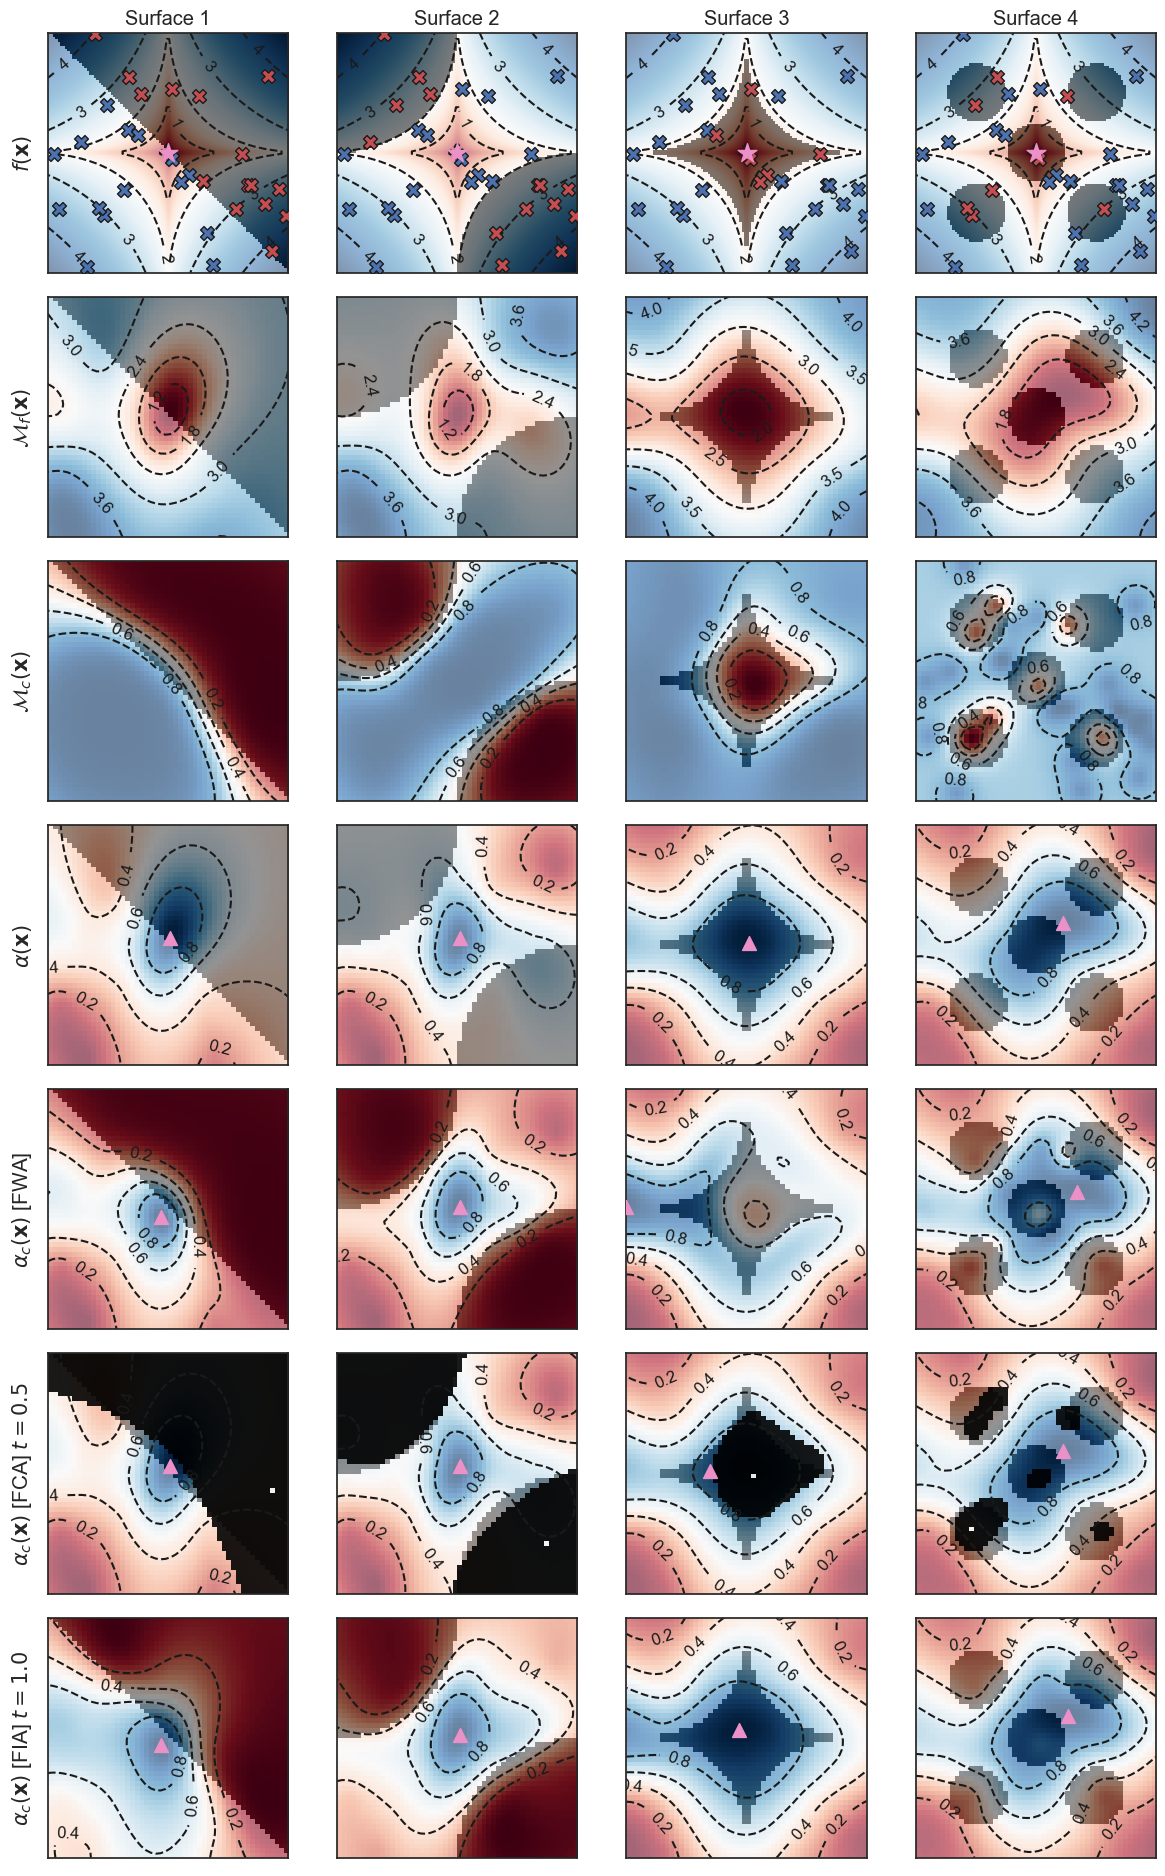

In [66]:
fig, axes = plt.subplots(7, 4, figsize=(12, 19), sharex=True, sharey=True)
# axes = axes.flatten()


for s_ix, surface in enumerate(surfaces):
    
    
    # overlaid function with observations plotted
    plot_constr_surface(surface['object'], ax=axes[0, s_ix], N=100, constr=True, contour=True, cmap=cmap)
    axes[0, s_ix].scatter(X[~surface['mask']].T[0], X[~surface['mask']].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
    axes[0, s_ix].scatter(X[surface['mask']].T[0], X[surface['mask']].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)
    
    
    
    # regression prediction
    info = campaigns_dict[f'{surface["name"]}-fwa']
    im = plot_contour(
                axes[1,s_ix], info['X0'], info['X1'], info['pred_mean_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[1,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')


#     axes[1,s_ix].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
#     axes[1,s_ix].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)


    # cla surrogate
    im = plot_contour(
                axes[2,s_ix], info['X0'], info['X1'], info['pred_feas_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[2,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')

#     axes[2,s_ix].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
#     axes[2,s_ix].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)


    # feasibility-unaware acquisition function
    # alpha(x)
    info = campaigns_dict[f'{surface["name"]}-fwa']
    im = plot_contour(
                axes[3,s_ix], info['X0'], info['X1'], info['pred_acqf_unconst_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[3,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')
    x_max = inp[np.argmax(info['pred_acqf_unconst'])]
    axes[3,s_ix].scatter(x_max[0], x_max[1], s=100, marker='^', color='#ec90c8', zorder=20)
    

    # feasibility-aware acquisition function
    # FWA
    info = campaigns_dict[f'{surface["name"]}-fwa']
    im = plot_contour(
                axes[4,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[4,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')
    x_max = inp[np.argmax(info['pred_acqf'])]
    axes[4,s_ix].scatter(x_max[0], x_max[1], s=100, marker='^', color='#ec90c8', zorder=20)
    
    # feasibility-aware acquisition function
    # FCA
    info = campaigns_dict[f'{surface["name"]}-fca']
    im = plot_contour(
                axes[5,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    # make mask based on the value of the FCA function  (t=0.5)
    fca_mask = np.ma.masked_where(info['pred_feas']>0.5, info['pred_feas'])
    fca_mask_Y = np.reshape(fca_mask, newshape=np.shape(info['X0']))
    
    axes[5,s_ix].imshow(
        info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none',
    )
    axes[5,s_ix].imshow(
        np.logical_not(fca_mask_Y), extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.9, interpolation='none',
    )
    fca_mask = fca_mask.mask
    print(fca_mask.shape, inp.shape)
    masked_inp = inp[fca_mask[:, 0],:]
    masked_vals = info['pred_acqf'][fca_mask]

    x_max = masked_inp[np.argmax(masked_vals)]
    axes[5,s_ix].scatter(x_max[0], x_max[1], s=100, marker='^', color='#ec90c8', zorder=20)

    # feasibility-aware acquisition function
    # FIA
    info = campaigns_dict[f'{surface["name"]}-fia']
    im = plot_contour(
                axes[6,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[6,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')
    x_max = inp[np.argmax(info['pred_acqf'])]
    axes[6,s_ix].scatter(x_max[0], x_max[1], s=100, marker='^', color='#ec90c8', zorder=20)
    
for i in range(4):
    axes[0,i].set_title(f'Surface {i+1}')
    

axes[0,0].set_ylabel(r'$f(\mathbf{x})$',fontsize=15)
axes[1,0].set_ylabel(r'$\mathcal{M}_f(\mathbf{x})$',fontsize=15)
axes[2,0].set_ylabel(r'$\mathcal{M}_c(\mathbf{x})$',fontsize=15)
axes[3,0].set_ylabel(r'$\alpha (\mathbf{x})$',fontsize=15)
axes[4,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FWA]',fontsize=15)
axes[5,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FCA] $t=0.5$',fontsize=15)
axes[6,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FIA] $t=1.0$',fontsize=15)

# tick_labels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
for ax in axes.flatten():
#     ax.set_xticklabels(tick_labels, fontsize=12)
#     ax.set_yticklabels(tick_labels, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

plt.subplots_adjust(
                    wspace=0.1,
                    hspace=0.1)
plt.savefig('all_methods_concept.png', dpi=300)

In [28]:
### CONCEPTUAL FIGURE FOR PAPER


# fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
# axes = axes.flatten()

cmap='RdBu'

# generate observations
n = 30
# random sampling
np.random.seed(30)
X = np.random.uniform(low=0, high=1, size=(n, 2))


surfaces = []
#----------
# Surface 1 
#----------
surface1 = DummySurface1()
obj1 = np.array(surface1.run_constr(X)).flatten()
mask1 = np.isnan(obj1)
X_feas1 = X[~mask1]
X_infs1 = X[mask1]
surfaces.append({'name':'surface1', 'object': surface1, 'obj': obj1, 'mask': mask1, 'X_feas': X_feas1, 'X_infs': X_infs1})

#----------
# Surface 2 
#----------
surface2 = DummySurface2()
obj2 = np.array(surface2.run_constr(X)).flatten()
mask2 = np.isnan(obj2)
X_feas2 = X[~mask2]
X_infs2 = X[mask2]
surfaces.append({'name':'surface2', 'object': surface2, 'obj': obj2, 'mask': mask2, 'X_feas': X_feas2, 'X_infs': X_infs2})


#----------
# Surface 3
#----------
surface3 = DummySurface3()
obj3 = np.array(surface3.run_constr(X)).flatten()
mask3 = np.isnan(obj3)
X_feas3 = X[~mask3]
X_infs3 = X[mask3]
surfaces.append({'name':'surface3', 'object': surface3, 'obj': obj3, 'mask': mask3, 'X_feas': X_feas3, 'X_infs': X_infs3})


#----------
# Surface 4
#----------
surface4 = DummySurface4()
obj4 = np.array(surface4.run_constr(X)).flatten()
mask4 = np.isnan(obj4)
X_feas4 = X[~mask4]
X_infs4 = X[mask4]
surfaces.append({'name':'surface4', 'object': surface4, 'obj': obj4, 'mask': mask4, 'X_feas': X_feas4, 'X_infs': X_infs4})



# generate surrogate models for all combinations
campaigns_dict =  {}
for surface_ix, surface in enumerate(surfaces):
    for feas_param in [0.5, 1., 2., 5., 10.] :
        
        print(f'\n\n GENERATING DATA FOR {surface["name"]}-FIA-{feas_param}...\n')
        
        # build olympus parameter space for 2d continuous example
        param_space = ParameterSpace()
        param_space.add(ParameterContinuous(name='param0'))
        param_space.add(ParameterContinuous(name='param1'))

        # build the campaign
        campaign = Campaign()
        campaign.set_param_space(param_space)

        # add the observations to the campaign
        for x, y in zip(X, surface['obj']):
            campaign.add_observation(x, y)

        # build the atlas planner
        planner = GPPlanner(
                goal='minimize',
                feas_strategy='fia',
                acquisition_type='ucb',#'ucb',
                feas_param=feas_param,
                vgp_iters=2000,
                vgp_lr=0.01
        )
        planner.set_param_space(param_space)
        
        _ = planner.recommend(campaign.observations)

        # build the test input 
        res = 50
        x0 = np.linspace(0,1,res)
        x1 = np.linspace(0,1,res)
        X0,X1 = np.meshgrid(x0,x1)

        inp = np.vstack([X0.ravel(),X1.ravel()]).T
        inp_torch = torch.tensor(inp)

        # PREDICTIONS OF REGRESSION SURROGATE
        pred_mean, pred_sigma = planner.reg_surrogate(inp_torch, return_np=True)
        pred_mean_Y = pred_mean.reshape(X0.shape) # for plotting

        # PREDICTIONS OF FEASIBILITY SURROGATE
        pred_feas = 1. - planner.cla_surrogate(inp_torch, return_np=True)
        pred_feas_Y = pred_feas.reshape(X0.shape) # for plotting

        # FEASIBILITY AWARE ACQUISITION
        pred_acqf = planner.acquisition_function(inp_torch, return_np=True)
        pred_acqf_Y = pred_acqf.reshape(X0.shape) # for plotting
        
        # FEASIBILITY UNAWARE ACQUISITION
        pred_acqf_unconst = planner.acquisition_function(inp_torch, return_np=True, unconstrained=True)
        pred_acqf_unconst_Y = pred_acqf_unconst.reshape(X0.shape) # for plotting


        # binary constraint stuff
        y_constr = np.array(surface['object'].eval_constr(inp)) 
        Y_constr = np.reshape(y_constr, newshape=np.shape(X0))
        
        campaigns_dict[f'{surface["name"]}-fia-{feas_param}'] = {
            'X0': X0, 'X1': X1, 
            'inp': inp,
            'pred_mean': pred_mean, 'pred_mean_Y': pred_mean_Y, 
            'pred_feas': pred_feas, 'pred_feas_Y': pred_feas_Y,
            'pred_acqf': pred_acqf, 'pred_acqf_Y': pred_acqf_Y,
            'pred_acqf_unconst': pred_acqf_unconst, 'pred_acqf_unconst_Y': pred_acqf_unconst_Y,
            'y_constr': y_constr, 'Y_constr': Y_constr,
        }




 GENERATING DATA FOR surface1-FIA-0.5...



[INFO] Regression surrogate GP trained in 0.073 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.671 sec (2000 epochs)  Loss : 0.363



 GENERATING DATA FOR surface1-FIA-1.0...



[INFO] Regression surrogate GP trained in 0.064 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.729 sec (2000 epochs)  Loss : 0.363

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)




 GENERATING DATA FOR surface1-FIA-2.0...



[INFO] Regression surrogate GP trained in 0.065 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.698 sec (2000 epochs)  Loss : 0.363



 GENERATING DATA FOR surface1-FIA-5.0...



[INFO] Regression surrogate GP trained in 0.065 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.788 sec (2000 epochs)  Loss : 0.363



 GENERATING DATA FOR surface1-FIA-10.0...



[INFO] Regression surrogate GP trained in 0.064 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.831 sec (2000 epochs)  Loss : 0.363



 GENERATING DATA FOR surface2-FIA-0.5...



[INFO] Regression surrogate GP trained in 0.059 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.829 sec (2000 epochs)  Loss : 0.449



 GENERATING DATA FOR surface2-FIA-1.0...



[INFO] Regression surrogate GP trained in 0.055 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.806 sec (2000 epochs)  Loss : 0.449



 GENERATING DATA FOR surface2-FIA-2.0...



[INFO] Regression surrogate GP trained in 0.058 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.709 sec (2000 epochs)  Loss : 0.449



 GENERATING DATA FOR surface2-FIA-5.0...



[INFO] Regression surrogate GP trained in 0.057 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.615 sec (2000 epochs)  Loss : 0.449



 GENERATING DATA FOR surface2-FIA-10.0...



[INFO] Regression surrogate GP trained in 0.058 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.563 sec (2000 epochs)  Loss : 0.449



 GENERATING DATA FOR surface3-FIA-0.5...



[INFO] Regression surrogate GP trained in 0.153 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.553 sec (2000 epochs)  Loss : 0.453



 GENERATING DATA FOR surface3-FIA-1.0...



[INFO] Regression surrogate GP trained in 0.154 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.615 sec (2000 epochs)  Loss : 0.453



 GENERATING DATA FOR surface3-FIA-2.0...



[INFO] Regression surrogate GP trained in 0.152 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.563 sec (2000 epochs)  Loss : 0.453



 GENERATING DATA FOR surface3-FIA-5.0...



[INFO] Regression surrogate GP trained in 0.151 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.538 sec (2000 epochs)  Loss : 0.453



 GENERATING DATA FOR surface3-FIA-10.0...



[INFO] Regression surrogate GP trained in 0.152 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.554 sec (2000 epochs)  Loss : 0.453



 GENERATING DATA FOR surface4-FIA-0.5...



[INFO] Regression surrogate GP trained in 0.085 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.62 sec (2000 epochs)   Loss : 0.557



 GENERATING DATA FOR surface4-FIA-1.0...



[INFO] Regression surrogate GP trained in 0.078 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.588 sec (2000 epochs)  Loss : 0.557



 GENERATING DATA FOR surface4-FIA-2.0...



[INFO] Regression surrogate GP trained in 0.078 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.582 sec (2000 epochs)  Loss : 0.557



 GENERATING DATA FOR surface4-FIA-5.0...



[INFO] Regression surrogate GP trained in 0.079 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.633 sec (2000 epochs)  Loss : 0.557



 GENERATING DATA FOR surface4-FIA-10.0...



[INFO] Regression surrogate GP trained in 0.079 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.604 sec (2000 epochs)  Loss : 0.557

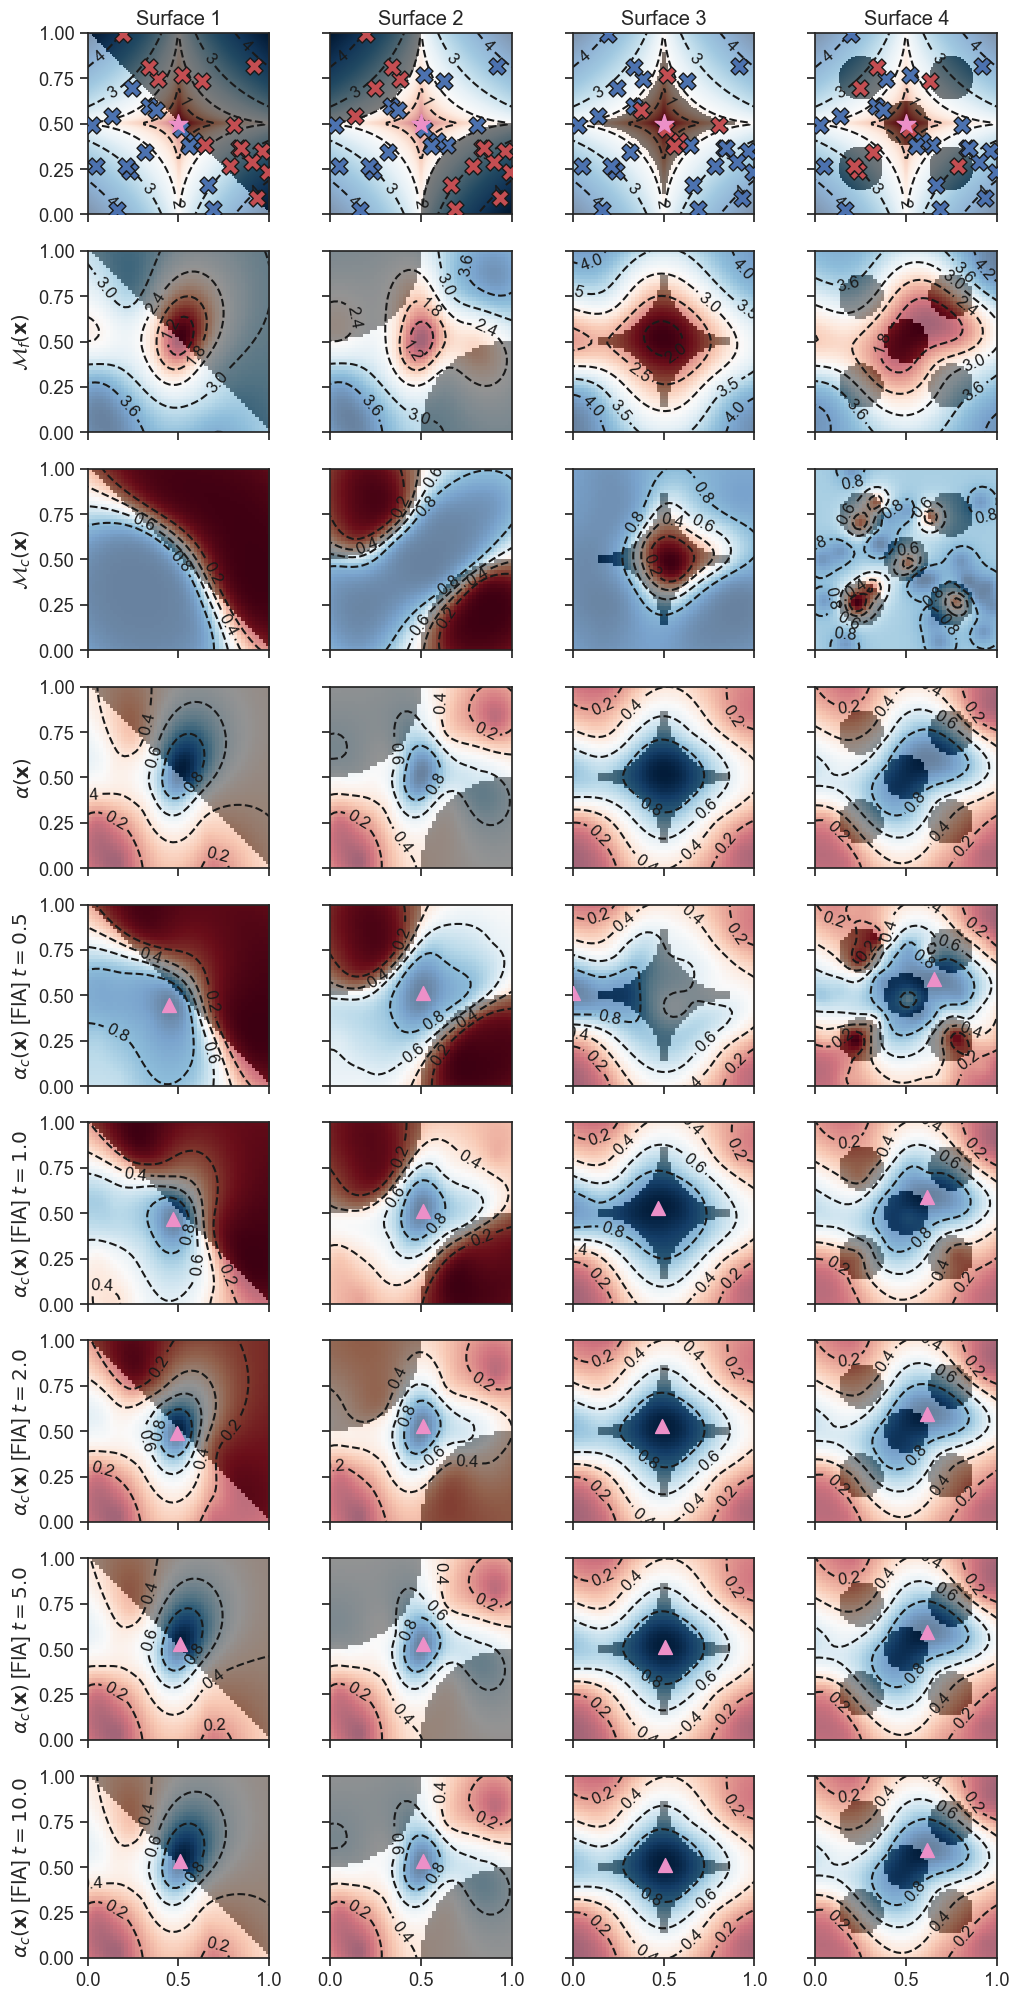

In [38]:
fig, axes = plt.subplots(9, 4, figsize=(12, 25), sharex=True, sharey=True)
# axes = axes.flatten()


for s_ix, surface in enumerate(surfaces):
    
    
    # overlaid function with observations plotted
    plot_constr_surface(surface['object'], ax=axes[0, s_ix], N=100, constr=True, contour=True, cmap=cmap)
    axes[0, s_ix].scatter(X[~surface['mask']].T[0], X[~surface['mask']].T[1], marker='X', s=150, color='b', edgecolor='k', zorder=10)
    axes[0, s_ix].scatter(X[surface['mask']].T[0], X[surface['mask']].T[1], marker='X', s=150, color='r', edgecolor='k', zorder=10)
    
    
    
    # regression prediction
    info = campaigns_dict[f'{surface["name"]}-fia-1.0']
    im = plot_contour(
                axes[1,s_ix], info['X0'], info['X1'], info['pred_mean_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[1,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')


#     axes[1,s_ix].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
#     axes[1,s_ix].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)


    # cla surrogate
    im = plot_contour(
                axes[2,s_ix], info['X0'], info['X1'], info['pred_feas_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[2,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')

#     axes[2,s_ix].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
#     axes[2,s_ix].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)


    # feasibility-unaware acquisition function
    # alpha(x)
    im = plot_contour(
                axes[3,s_ix], info['X0'], info['X1'], info['pred_acqf_unconst_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[3,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')

    
  
    # FIA-0.5
    info = campaigns_dict[f'{surface["name"]}-fia-0.5']
    im = plot_contour(
                axes[4,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[4,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')
    x_max = inp[np.argmax(info['pred_acqf'])]
    axes[4,s_ix].scatter(x_max[0], x_max[1], s=100, marker='^', color='#ec90c8', zorder=20)
    
    # FIA-1.0
    info = campaigns_dict[f'{surface["name"]}-fia-1.0']
    im = plot_contour(
                axes[5,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[5,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')
    x_max = inp[np.argmax(info['pred_acqf'])]
    axes[5,s_ix].scatter(x_max[0], x_max[1], s=100, marker='^', color='#ec90c8', zorder=20)
    
    # FIA-2.0
    info = campaigns_dict[f'{surface["name"]}-fia-2.0']
    im = plot_contour(
                axes[6,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[6,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')
    x_max = inp[np.argmax(info['pred_acqf'])]
    axes[6,s_ix].scatter(x_max[0], x_max[1], s=100, marker='^', color='#ec90c8', zorder=20)

    # FIA-5.0
    info = campaigns_dict[f'{surface["name"]}-fia-5.0']
    im = plot_contour(
                axes[7,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[7,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')
    x_max = inp[np.argmax(info['pred_acqf'])]
    axes[7,s_ix].scatter(x_max[0], x_max[1], s=100, marker='^', color='#ec90c8', zorder=20)
    
    # FIA-10.0
    info = campaigns_dict[f'{surface["name"]}-fia-10.0']
    im = plot_contour(
                axes[8,s_ix], info['X0'], info['X1'], info['pred_acqf_Y'], xlims=[0,1], ylims=[0,1], alpha=1., 
                contour_lines=True, contour_labels=True, labels_fs=12, 
                labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
            )
    axes[8,s_ix].imshow(info['Y_constr'], extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')
    x_max = inp[np.argmax(info['pred_acqf'])]
    axes[8,s_ix].scatter(x_max[0], x_max[1], s=100, marker='^', color='#ec90c8', zorder=20)
    
    
for i in range(4):
    axes[0,i].set_title(f'Surface {i+1}')

axes[1,0].set_ylabel(r'$\mathcal{M}_f(\mathbf{x})$')
axes[2,0].set_ylabel(r'$\mathcal{M}_c(\mathbf{x})$')
axes[3,0].set_ylabel(r'$\alpha (\mathbf{x})$')
axes[4,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FIA] $t=0.5$')
axes[5,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FIA] $t=1.0$')
axes[6,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FIA] $t=2.0$')
axes[7,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FIA] $t=5.0$')
axes[8,0].set_ylabel(r'$\alpha_c (\mathbf{x})$ [FIA] $t=10.0$')

plt.savefig('ucb_fia_vary_t.png', dpi=300)

[INFO] Regression surrogate GP trained in 0.097 sec

/Users/rileyhickman/mambaforge/envs/atlas/lib/python3.10/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[INFO]  Classification surrogate VGP trained in 3.536 sec (2000 epochs)  Loss : 0.362

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_52309/420900995.py:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels, fontsize=12)
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_52309/420900995.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tick_labels, fontsize=12)


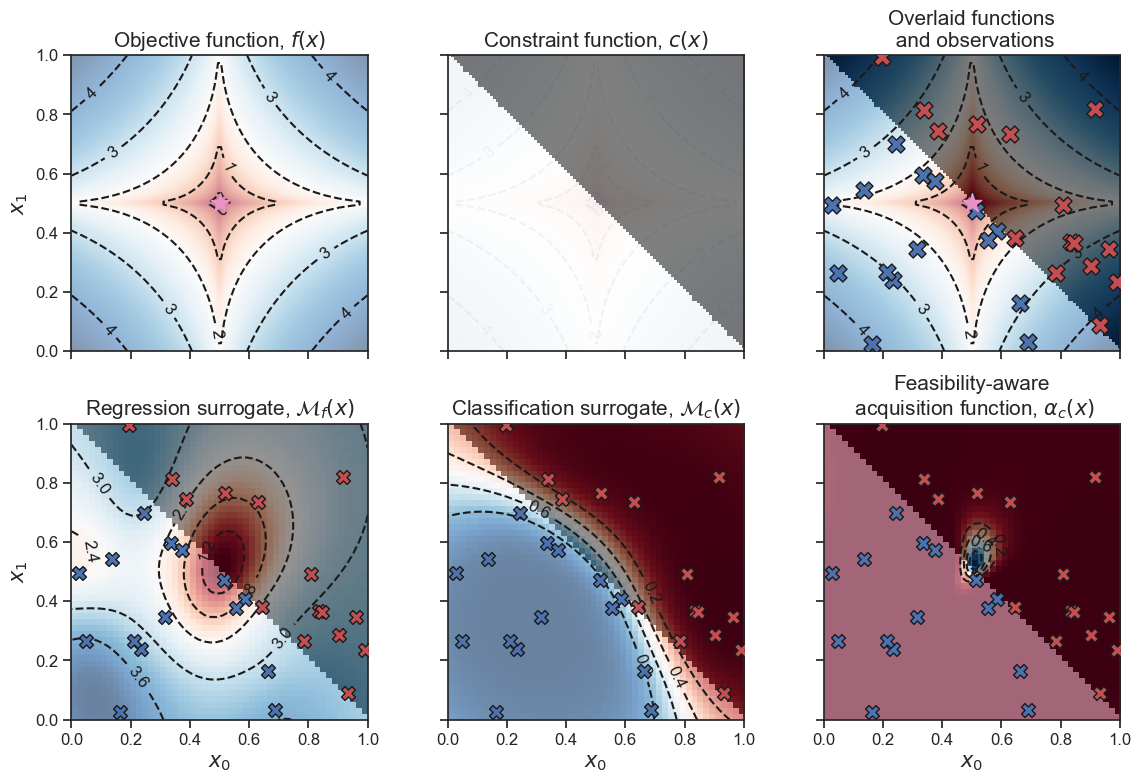

In [4]:
# CONCEPTUAL FIGURE FOR PAPER


fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

cmap='RdBu'

# generate data
surface = DummySurface1()
n = 30

# random sampling
np.random.seed(30)
X = np.random.uniform(low=0, high=1, size=(n, 2))
obj = np.array(surface.run_constr(X)).flatten()

mask = np.isnan(obj)
X_feas = X[~mask]
X_infs = X[mask]

# build olympus parameter space for 2d continuous example
param_space = ParameterSpace()
param_space.add(ParameterContinuous(name='param0'))
param_space.add(ParameterContinuous(name='param1'))

# build the campaign
campaign = Campaign()
campaign.set_param_space(param_space)

# add the observations to the campaign
for x, y in zip(X, obj):
    campaign.add_observation(x, y)
    
# build the atlas planner
planner = GPPlanner(
        goal='minimize',
        feas_strategy='fwa',
        acquisition_type='ei',#'ucb',
        feas_param=0.,
        vgp_iters=2000,
        vgp_lr=0.01
)
planner.set_param_space(param_space)

_ = planner.recommend(campaign.observations)


# build the test input 
res = 50
x0 = np.linspace(0,1,res)
x1 = np.linspace(0,1,res)
X0,X1 = np.meshgrid(x0,x1)

inp = np.vstack([X0.ravel(),X1.ravel()]).T
inp_torch = torch.tensor(inp)
    

# PREDICTIONS OF REGRESSION SURROGATE
pred_mean, pred_sigma = planner.reg_surrogate(inp_torch, return_np=True)
pred_mean_Y = pred_mean.reshape(X0.shape) # for plotting

# PREDICTIONS OF FEASIBILITY SURROGATE
pred_feas = 1. - planner.cla_surrogate(inp_torch, return_np=True)
pred_feas_Y = pred_feas.reshape(X0.shape) # for plotting

# FEASIBILITY AWARE ACQUISITION
pred_acqf = planner.acquisition_function(inp_torch, return_np=True)
pred_acqf_Y = pred_acqf.reshape(X0.shape) # for plotting
    
    

# binary constraint stuff
y_constr = np.array(surface.eval_constr(inp))
Y_constr = np.reshape(y_constr, newshape=np.shape(X0))


# objective function
plot_constr_surface(surface, ax=axes[0], N=100, constr=False, cmap=cmap, alpha=0.5)

# constraint function
plot_constr_surface(
    surface, ax=axes[1], N=100, constr=True, contour=True, plot_min=False, cmap=cmap, alpha=0.1, contour_alpha=0.05,
)

# overlaid function with observations plotted
plot_constr_surface(surface, ax=axes[2], N=100, constr=True, contour=True, cmap=cmap)
axes[2].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=150, color='b', edgecolor='k', zorder=10)
axes[2].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=150, color='r', edgecolor='k', zorder=10)


# regression surrogate
im = plot_contour(
            axes[3], X0, X1, pred_mean_Y, xlims=[0,1], ylims=[0,1], alpha=1., 
            contour_lines=True, contour_labels=True, labels_fs=12, 
            labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
        )
axes[3].imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')


axes[3].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
axes[3].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)


# cla surrogate
im = plot_contour(
            axes[4], X0, X1, pred_feas_Y, xlims=[0,1], ylims=[0,1], alpha=1., 
            contour_lines=True, contour_labels=True, labels_fs=12, 
            labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
        )
axes[4].imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')

axes[4].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
axes[4].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)


# feasibility-aware acquisition function
im = plot_contour(
            axes[5], X0, X1, pred_acqf_Y, xlims=[0,1], ylims=[0,1], alpha=1., 
            contour_lines=True, contour_labels=True, labels_fs=12, 
            labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu'
        )
axes[5].imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.4, interpolation='none')

axes[5].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
axes[5].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)


for ix in [0, 3]:
    axes[ix].set_ylabel(r'$x_1$',fontsize=15)
for ix in [3, 4, 5]:
    axes[ix].set_xlabel(r'$x_0$',fontsize=15)
    
tick_labels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for ax in axes:
    ax.set_xticklabels(tick_labels, fontsize=12)
    ax.set_yticklabels(tick_labels, fontsize=12)


axes[0].set_title(r'Objective function, $f(x)$',fontsize=15)
axes[1].set_title(r'Constraint function, $c(x)$',fontsize=15)
axes[2].set_title(f'Overlaid functions\n and observations',fontsize=15)
axes[3].set_title(r'Regression surrogate, $\mathcal{M}_f(x)$',fontsize=15)
axes[4].set_title(r'Classification surrogate, $\mathcal{M}_c(x)$',fontsize=15)
axes[5].set_title('Feasibility-aware\n acquisition function,'+r' $\alpha_c(x)$',fontsize=15)
    
plt.tight_layout()
plt.savefig('concept_figure_ei.png',dpi=300)

In [ ]:
# build observations for Gryffin
observations = []
for x, o in zip(X, obj):
    d = {}
    d['x0'] = x[0]
    d['x1'] = x[1]
    d['obj'] = o
    observations.append(d)
    
observations[:5]

In [ ]:
config = {
     "general": {
             "batches": 1,
             "parallel": False,
             "boosted":  False,
             "sampling_strategies": 1,
             "random_seed":42,
             "feas_approach": "fwa", 
             "feas_sensitivity": 1,
             "acquisition_optimizer": "genetic"
                },
    "model": {'num_epochs':  2 * 10**3,
              'learning_rate': 0.05,
              },
    "parameters": [
        {"name": "x0", "type": "continuous", "low": 0., "high": 1.},
        {"name": "x1", "type": "continuous", "low": 0., "high": 1.}
    ],
    "objectives": [
        {"name": "obj", "goal": "min"}
    ]
}

gryffin = Gryffin(config_dict=config, silent=True)
#gryffin.recommend(observations=observations, sampling_strategies=[0])
gryffin.build_surrogate(observations)

In [64]:
N = 100
x0 = np.linspace(0, 1, N)
x1 = np.linspace(0, 1, N)
X0, X1 = np.meshgrid(x0, x1)
df = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})

In [65]:
y = gryffin.get_feasibility_surrogate(df, threshold=None)
Y = np.reshape(y, newshape=np.shape(X0))

y_constr = np.array(surface.eval_constr(df.to_numpy()))
Y_constr = np.reshape(y_constr, newshape=np.shape(X0))

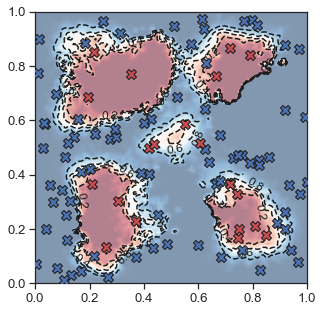

In [66]:
fig, ax = plt.subplots(figsize=(5,5))

_ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')

ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)

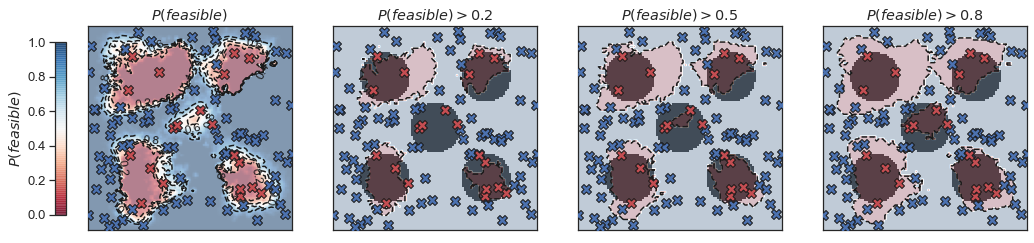

In [67]:



fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4), sharex=True, sharey=True)
  
# First plot with prob feasible
im = plot_contour(axes[0], X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')

axes[0].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
axes[0].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)  
axes[0].set_title('$P(feasible)$')

# color bar
fig.subplots_adjust(left=0.03)
cbar_ax = fig.add_axes([0.0, 0.2, 0.01, 0.6])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
_ = cbar_ax.set_ylabel('$P(feasible)$')
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')

# Plots with binary outcome
for ax, t in zip(axes[1:], [0.20, 0.5, 0.8]):
    plot_binary_surface(ax, Y, threshold=t)
    
    ax.imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')

    ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
    ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)
    
    ax.set_title(f'$P(feasible) > {t}$')
    

# labels etc
_ = axes[0].set_yticks([])
_ = axes[0].set_xticks([])

In [68]:
def get_classification_model(surface_class, config, n=100, random_seed=42):
    
    surface = surface_class()

    # random sampling
    np.random.seed(random_seed)
    X = np.random.uniform(low=0, high=1, size=(n, 2))
    obj = np.array(surface.run_constr(X)).flatten()
    mask = np.isnan(obj)
    
    # build observations for Gryffin
    observations = []
    for x, o in zip(X, obj):
        d = {}
        d['x0'] = x[0]
        d['x1'] = x[1]
        d['obj'] = o
        observations.append(d)
        
    # run Gryffin
    N = 100
    x0 = np.linspace(0, 1, N)
    x1 = np.linspace(0, 1, N)
    X0, X1 = np.meshgrid(x0, x1)
    df = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})

    gryffin = Gryffin(config_dict=config, silent=True)
    #gryffin.recommend(observations=observations, sampling_strategies=[0])
    gryffin.build_surrogate(observations=observations)
    
    # get prob feas and constr
    y = gryffin.get_feasibility_surrogate(df, threshold=None)
    Y = np.reshape(y, newshape=np.shape(X0))
    y_constr = np.array(surface.eval_constr(df.to_numpy()))
    Y_constr = np.reshape(y_constr, newshape=np.shape(X0))

    return X, X0, X1, Y, Y_constr, mask


def plot_binary_surface(ax, Y, threshold=0.5):

    Y_binary = np.where(Y > threshold, 1.0, Y)  # if Y>0.5 return 1.0 else Y
    Y_binary = np.where(Y_binary <= threshold, 0.0, Y_binary)

    _ = plot_contour(ax, X0, X1, Y_binary, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=False, 
                 labels_fs=12, labels_fmt='%.2f', n_contour_lines=0, contour_alpha=1, cbar=False, cmap='RdBu')


def plot_row(axes, X, X0, X1, Y, Y_constr, mask):
  
    # First plot with prob feasible
    im = plot_contour(axes[0], X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')

    axes[0].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
    axes[0].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)  

    # Plots with binary outcome
    for ax, t in zip(axes[1:], [0.20, 0.5, 0.8]):
        plot_binary_surface(ax, Y, threshold=t)
        ax.imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)
        
    return im

In [120]:
examples = {}

for i, S, rs in zip([0,1,2,3], 
                    [DummySurface1, DummySurface2, DummySurface3, DummySurface4], 
                    [0, 3, 4, 26]):
    print(f'processing surface No {i+1}...')
    X, X0, X1, Y, Y_constr, mask = get_classification_model(surface_class=S, n=50, config=config, random_seed=rs)
    
    examples[i] = {}
    examples[i]['X'] = X
    examples[i]['X0'] = X0
    examples[i]['X1'] = X1
    examples[i]['Y'] = Y
    examples[i]['Y_constr'] = Y_constr
    examples[i]['mask'] = mask

processing surface No 1...
processing surface No 2...
processing surface No 3...
processing surface No 4...


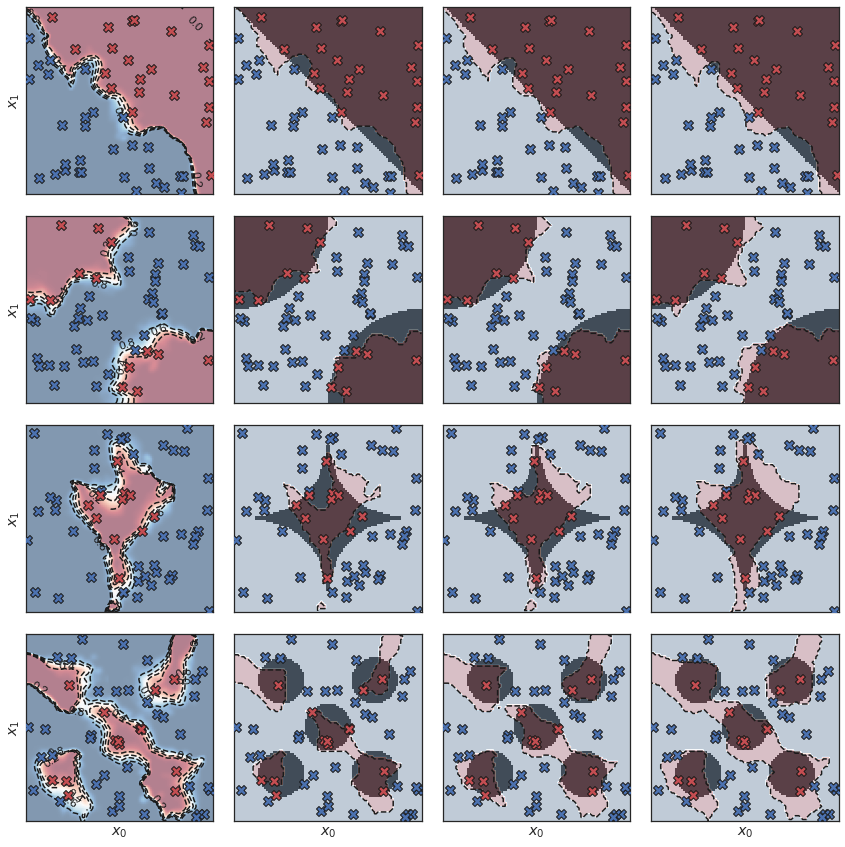

In [94]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True, sharey=True)

# example 1
i = 0
im0 = plot_row(axes[i, :], examples[i]['X'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 2
i = 1
im1 = plot_row(axes[i, :], examples[i]['X'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 3
i = 2
im2 = plot_row(axes[i, :], examples[i]['X'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 4
i = 3
im3 = plot_row(axes[i, :], examples[i]['X'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])


# color bar
#fig.subplots_adjust(left=0.03)
#cbar_ax = fig.add_axes([0.0, 0.3, 0.01, 0.4])  # [left, bottom, width, height]
#fig.colorbar(im, cax=cbar_ax)
#_ = cbar_ax.set_ylabel('$P(feasible)$')
#cbar_ax.yaxis.set_ticks_position('left')
#cbar_ax.yaxis.set_label_position('left')

#fig.subplots_adjust(bottom=0.03)
#cbar_ax0 = fig.add_axes([0.046, 0.0, 0.2, 0.01])  # [left, bottom, width, height]
#fig.colorbar(im, cax=cbar_ax0, orientation='horizontal')
#_ = cbar_ax0.set_xlabel('$P(feasible)$')

#fig.subplots_adjust(top=1.05)
#cbar_ax = fig.add_axes([0.046, 1.0, 0.2, 0.01])  # [left, bottom, width, height]
#fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
#_ = cbar_ax.set_xlabel('$P(feasible)$')
#cbar_ax.xaxis.set_ticks_position('bottom')
#cbar_ax.xaxis.set_label_position('top')

# labels etc
_ = axes[0,0].set_yticks([])
_ = axes[0,0].set_xticks([])

for j in [0,1,2,3]:
    axes[-1, j].set_xlabel('$x_0$')
    axes[j, 0].set_ylabel('$x_1$')
    

#axes[0,0].set_title('$P(feasible)$')
#axes[0,1].set_title('$P(feasible) > 0.2$')
#axes[0,2].set_title('$P(feasible) > 0.5$')
#axes[0,3].set_title('$P(feasible) > 0.8$')

plt.tight_layout()
#fig.savefig('continuous_examples.pdf', bbox_inches='tight')

## Categorical

In [152]:
def plot_constr_surface_cat(surface, ax=None, mark_min=False, cbar=False):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        
        
    domain = np.arange(surface.num_opts)
    Z = np.zeros((surface.num_opts, surface.num_opts))
    Z_feas = np.empty((surface.num_opts, surface.num_opts))
    X = []
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
            X.append(x)
            loss_value = surface.run(x)
            #feas_bool = surface.eval_constr({'x0': x[0], 'x1': x[1]})
            feas_bool = surface.eval_constr(x)
            Z[y_index, x_index] = loss_value
            Z_feas[y_index, x_index] = feas_bool
            
    # scale Camel for visualization 
    if type(surface).__name__ == 'CatCamelConstr':
        Z = np.log(Z)

    mappable = ax.imshow(Z, origin='lower', cmap = plt.get_cmap('golem'))
    _ = ax.imshow(Z_feas, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.7)

In [153]:
class CatDummySurface1(CatDejongConstr):    
    def is_feasible(self, sample):
        Xi = self.str2array(sample)
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        if x0 + x1 > 19:
            return False
        return True
    
    
class CatDummySurface2(CatDejongConstr):    
    def is_feasible(self, sample):
        Xi = self.str2array(sample)
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        if x0**2 + (x1-20)**2 < 110:
            return False
        if (x0-20)**2 + x1**2 < 110:
            return False
        return True
    
    
class CatDummySurface3(CatDejongConstr):    
    def is_feasible(self, sample):
        Xi = self.str2array(sample)
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        if np.sum(np.sqrt(np.abs(Xi-10))) < 3:
            return False

        return True
    
class CatDummySurface4(CatDejongConstr):    
    def is_feasible(self, sample):
        Xi = self.str2array(sample)
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        centers = [[5, 5],[5, 15],[10, 10], [15, 5],[15, 15]]
        
        for center in centers:
            if (x0 - center[0])**2 + (x1 - center[1])**2 < 6:
                return False
        return True

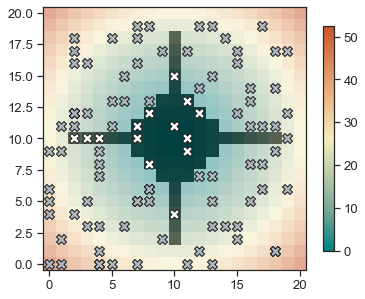

In [154]:
# plot surface
surface = CatDummySurface3()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5,5))
plot_constr_surface_cat(surface, ax=ax, cbar=True)

# random sampling
np.random.seed(15)
n = 100
X_int = np.random.choice(range(20), size=(n, 2))

obj = []
X = []
for xi in X_int:
    param = {'x0':f'x_{xi[0]}', 'x1':f'x_{xi[1]}'}
    o = surface.run_constr(xi)
    X.append([f'x_{xi[0]}', f'x_{xi[1]}'])
    obj.append(o)


mask = np.isnan(obj)
X_feas = X_int[~mask]
X_infs = X_int[mask]

ax.scatter(X_int[~mask].T[0], X_int[~mask].T[1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
ax.scatter(X_int[mask].T[0], X_int[mask].T[1], marker='X', s=100, color='white', edgecolor='k', zorder=10)

plt.tight_layout()

In [155]:
# build observations for Gryffin
observations = []
for x, o in zip(X, obj):
    d = {}
    d['x0'] = x[0]
    d['x1'] = x[1]
    d['obj'] = o
    observations.append(d)
    
observations[:5]

[{'x0': 'x_8', 'x1': 'x_12', 'obj': nan},
 {'x0': 'x_5', 'x1': 'x_0', 'obj': 32.768},
 {'x0': 'x_7', 'x1': 'x_11', 'obj': nan},
 {'x0': 'x_15', 'x1': 'x_17', 'obj': 19.398656000000003},
 {'x0': 'x_13', 'x1': 'x_0', 'obj': 28.573696}]

In [156]:
cat_details_naive = {k:None for k in [f'x_{i}' for i in range(21)]}
cat_details_wdesc = {k:[v] for v,k in enumerate([f'x_{i}' for i in range(21)])}

config = {
     "general": {
             "num_cpus": 1,
             "auto_desc_gen": False,
             "batches": 1,
             "caching": True,
             "boosted":  False,
             "sampling_strategies": 1,
             "random_seed":42,
             "feas_approach": "fca", 
             "feas_param": 0.5,
             "acquisition_optimizer": "genetic"
                },
    "model": {'num_epochs':  2 * 10**3,
              'learning_rate': 0.05,
              },
    "parameters": [
         {"name": "x0", "type": "categorical", "category_details": cat_details_wdesc},
         {"name": "x1", "type": "categorical", "category_details": cat_details_wdesc}
    ],
    "objectives": [
        {"name": "obj", "goal": "min"}
    ]
}

gryffin = Gryffin(config_dict=config, silent=False)
#gryffin.recommend(observations=observations, sampling_strategies=[0])
gryffin.build_surrogate(observations)

⠧ Training the Bayesian neural network...

Bayesian neural network trained in 11.1 s

─────────────────────────────────── Summary ────────────────────────────────────

Memory usage: 1 GB, 1142 MB, 226 kB

===================================== End ======================================

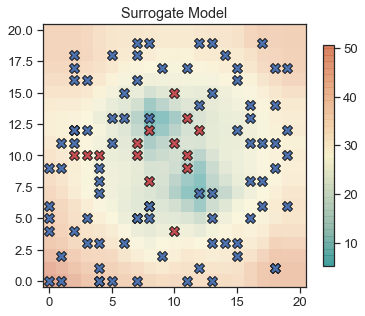

In [157]:
x0 = [f'x_{i}' for i in range(21)]
x1 = [f'x_{i}' for i in range(21)]
X0, X1 = np.meshgrid(x0, x1)
df = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})


# -------
# compute
# -------
y = gryffin.get_regression_surrogate(df)
Y = np.reshape(y, newshape=np.shape(X0))

y_constr = np.array(surface.eval_constr(df.to_numpy()))
Y_constr = np.reshape(y_constr, newshape=np.shape(X0))

# ----
# plot
# ----
fig, ax = plt.subplots(figsize=(5.5, 5))

xlims = [0,20]
ylims = [0,20]

mappable = ax.imshow(Y, origin='lower', cmap='golem', alpha=0.5)
cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.7)

ax.scatter(X_int[~mask].T[0], X_int[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
ax.scatter(X_int[mask].T[0], X_int[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)

ax.set_title('Surrogate Model')
plt.tight_layout()

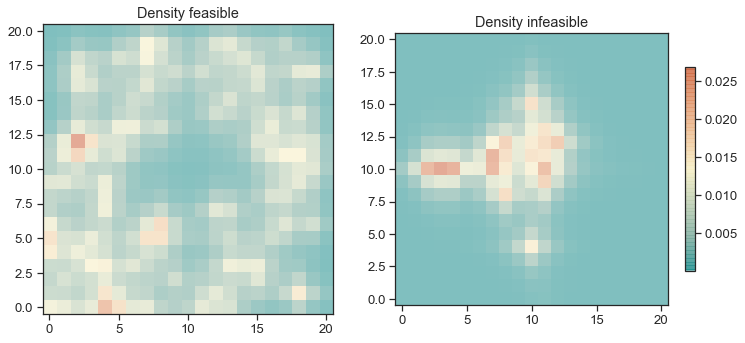

In [158]:
x0 = [f'x_{i}' for i in range(21)]
x1 = [f'x_{i}' for i in range(21)]
X0, X1 = np.meshgrid(x0, x1)
df = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})


# -------
# compute
# -------
y = gryffin.get_kernel_density_estimate(df, separate_kwn_ukwn=True)
Y_0 = np.reshape(y.T[0], newshape=np.shape(X0))
Y_1 = np.reshape(y.T[1], newshape=np.shape(X0))

# ----
# plot
# ----
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 5))

xlims = [0,20]
ylims = [0,20]

mappable = ax1.imshow(Y_0, origin='lower', cmap='golem', alpha=0.5)
mappable = ax2.imshow(Y_1, origin='lower', cmap='golem', alpha=0.5)

cbar = plt.colorbar(mappable=mappable, ax=ax2, shrink=0.7)

ax1.scatter(X_int[~mask].T[0], X_int[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10, alpha=0)
ax2.scatter(X_int[mask].T[0], X_int[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10, alpha=0)

ax1.set_title('Density feasible')
ax2.set_title('Density infeasible')
plt.tight_layout()

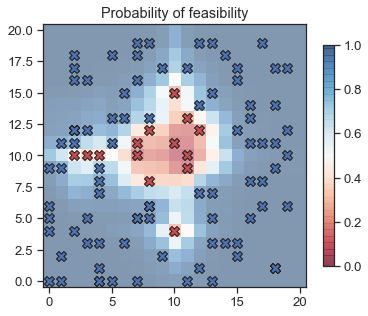

In [159]:
# -------
# compute
# -------
y = gryffin.get_feasibility_surrogate(df, threshold=None)
Y = np.reshape(y, newshape=np.shape(X0))

y_constr = np.array(surface.eval_constr(df.to_numpy()))
Y_constr = np.reshape(y_constr, newshape=np.shape(X0))

# ----
# plot
# ----
fig, ax = plt.subplots(figsize=(5.5, 5))

xlims = [0,20]
ylims = [0,20]

mappable = ax.imshow(Y, origin='lower', cmap='RdBu', alpha=0.5, vmin=0, vmax=1)
cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.7)

ax.scatter(X_int[~mask].T[0], X_int[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
ax.scatter(X_int[mask].T[0], X_int[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)

ax.set_title('Probability of feasibility')
plt.tight_layout()

In [160]:
def get_classification_model_for_cat(surface_class, config, n=100, random_seed=42):
    
    surface = surface_class()

    # random sampling
    
    # random sampling
    np.random.seed(15)
    n = 100
    X_int = np.random.choice(range(20), size=(n, 2))
    
    obj = []
    X = []
    for xi in X_int:
        param = {'x0':f'x_{xi[0]}', 'x1':f'x_{xi[1]}'}
        o = surface.run_constr(xi)
        X.append([f'x_{xi[0]}', f'x_{xi[1]}'])
        obj.append(o)
        
    mask = np.isnan(obj)
    
    # build observations for Gryffin
    observations = []
    for x, o in zip(X, obj):
        d = {}
        d['x0'] = x[0]
        d['x1'] = x[1]
        d['obj'] = o
        observations.append(d)
        
    # run Gryffin    
    gryffin = Gryffin(config_dict=config, silent=True)
    gryffin.build_surrogate(observations)

    # get model
    x0 = [f'x_{i}' for i in range(21)]
    x1 = [f'x_{i}' for i in range(21)]
    X0, X1 = np.meshgrid(x0, x1)
    df = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})

    y = gryffin.get_feasibility_surrogate(df)
    Y = np.reshape(y, newshape=np.shape(X0))

    y_constr = np.array(surface.eval_constr(df.to_numpy()))
    Y_constr = np.reshape(y_constr, newshape=np.shape(X0))

    return X, X_int, X0, X1, Y, Y_constr, mask


def plot_binary_surface_cat(ax, Y, threshold=0.5):

    Y_binary = np.where(Y > threshold, 1.0, Y)  # if Y>0.5 return 1.0 else Y
    Y_binary = np.where(Y_binary <= threshold, 0.0, Y_binary)
    
    mappable = ax.imshow(Y_binary, origin='lower', cmap='RdBu', alpha=0.5, vmin=0, vmax=1)
    #cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.7)

    #_ = plot_contour(ax, X0, X1, Y_binary, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=False, 
    #             labels_fs=12, labels_fmt='%.2f', n_contour_lines=0, contour_alpha=1, cbar=False, cmap='RdBu')


def plot_row_cat(axes, X, X0, X1, Y, Y_constr, mask):
  
    # First plot with prob feasible
    #im = plot_contour(axes[0], X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
    #             labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')
    mappable = axes[0].imshow(Y, origin='lower', cmap='RdBu', alpha=0.5, vmin=0, vmax=1)

    axes[0].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
    axes[0].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)  

    # Plots with binary outcome
    for ax, t in zip(axes[1:], [0.20, 0.5, 0.8]):
        plot_binary_surface_cat(ax, Y, threshold=t)
        ax.imshow(Y_constr, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)
        
    return im

In [161]:
examples = {}

for i, S, rs in zip([0,1,2,3], 
                    [CatDummySurface1, CatDummySurface2, CatDummySurface3, CatDummySurface4], 
                    [0, 42, 8, 15]):
    print(f'processing surface No {i+1}...')
    X, X_int, X0, X1, Y, Y_constr, mask = get_classification_model_for_cat(surface_class=S, n=50, config=config, random_seed=rs)
    
    examples[i] = {}
    examples[i]['X'] = X
    examples[i]['X_int'] = X_int
    examples[i]['X0'] = X0
    examples[i]['X1'] = X1
    examples[i]['Y'] = Y
    examples[i]['Y_constr'] = Y_constr
    examples[i]['mask'] = mask

processing surface No 1...
processing surface No 2...
processing surface No 3...
processing surface No 4...


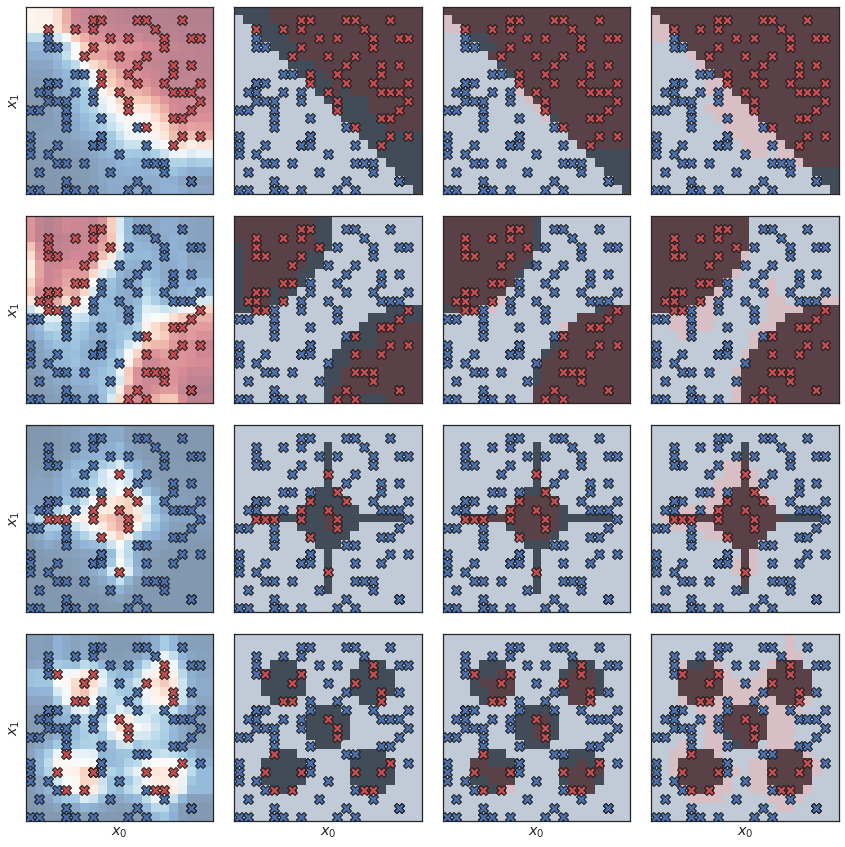

In [163]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True, sharey=True)

# example 1
i = 0
im0 = plot_row_cat(axes[i, :], examples[i]['X_int'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 2
i = 1
im1 = plot_row_cat(axes[i, :], examples[i]['X_int'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 3
i = 2
im2 = plot_row_cat(axes[i, :], examples[i]['X_int'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 4
i = 3
im3 = plot_row_cat(axes[i, :], examples[i]['X_int'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# labels etc
_ = axes[0,0].set_yticks([])
_ = axes[0,0].set_xticks([])

for j in [0,1,2,3]:
    axes[-1, j].set_xlabel('$x_0$')
    axes[j, 0].set_ylabel('$x_1$')
    

#axes[0,0].set_title('$P(feasible)$')
#axes[0,1].set_title('$P(feasible) > 0.2$')
#axes[0,2].set_title('$P(feasible) > 0.5$')
#axes[0,3].set_title('$P(feasible) > 0.8$')

plt.tight_layout()
#fig.savefig('classification_examples.pdf', bbox_inches='tight')

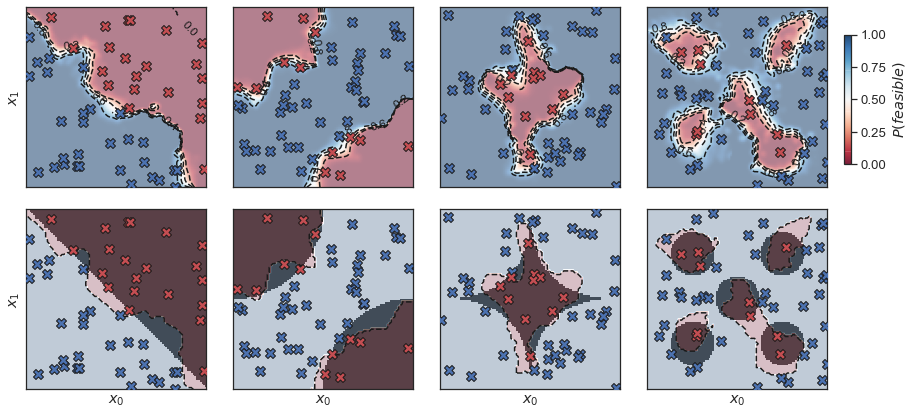

In [145]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharex=True, sharey=True)


def plot_classification_w_scatter(ax, i, examples, thres=None):
    Y = examples[i]['Y']
    X = examples[i]['X']
    X0 = examples[i]['X0']
    X1 = examples[i]['X1']
    Y_constr = examples[i]['Y_constr']
    mask = examples[i]['mask']
    if thres is None:
        im = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)  
    else:
        plot_binary_surface(ax, Y, threshold=thres)
        ax.imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)

# row 1
plot_classification_w_scatter(ax=axes[0,0], i=0, examples=examples)
plot_classification_w_scatter(ax=axes[0,1], i=1, examples=examples)
plot_classification_w_scatter(ax=axes[0,2], i=2, examples=examples)
plot_classification_w_scatter(ax=axes[0,3], i=3, examples=examples)

# row 2
plot_classification_w_scatter(ax=axes[1,0], i=0, examples=examples, thres=0.5)
plot_classification_w_scatter(ax=axes[1,1], i=1, examples=examples, thres=0.5)
plot_classification_w_scatter(ax=axes[1,2], i=2, examples=examples, thres=0.5)
plot_classification_w_scatter(ax=axes[1,3], i=3, examples=examples, thres=0.5)

# labels etc
_ = axes[0,0].set_yticks([])
_ = axes[0,0].set_xticks([])

for j in [0,1,2,3]:
    axes[-1, j].set_xlabel('$x_0$')
    if j in [0,1]:
        axes[j, 0].set_ylabel('$x_1$')
    
fig.subplots_adjust(left=0.03)
cbar_ax = fig.add_axes([0.99, 0.6, 0.008, 0.3])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
_ = cbar_ax.set_ylabel('$P(feasible)$')
cbar_ax.yaxis.set_ticks_position('right')
cbar_ax.yaxis.set_label_position('right')

plt.tight_layout()
fig.savefig('continuous_examples.pdf', bbox_inches='tight')

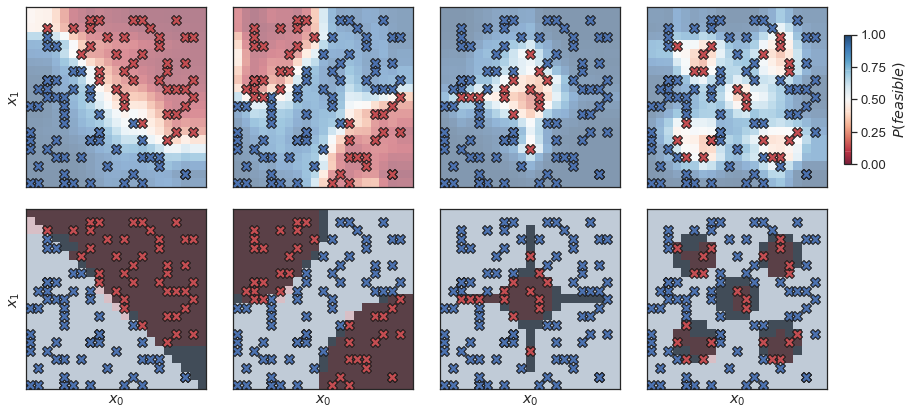

In [171]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharex=True, sharey=True)


def plot_classification_w_scatter(ax, i, examples, thres=None, categorical=False):
    Y = examples[i]['Y']
    X = examples[i]['X_int']
    X0 = examples[i]['X0']
    X1 = examples[i]['X1']
    Y_constr = examples[i]['Y_constr']
    mask = examples[i]['mask']
    if thres is None:
        if categorical is False:
            im = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')
        else:
            mappable = ax.imshow(Y, origin='lower', cmap='RdBu', alpha=0.5, vmin=0, vmax=1)
        
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)  
    else:
        if categorical is False:
            plot_binary_surface(ax, Y, threshold=thres)
            ax.imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        else:
            plot_binary_surface_cat(ax, Y, threshold=thres)
            ax.imshow(Y_constr, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)
        
# row 1        
plot_classification_w_scatter(ax=axes[0,0], i=0, examples=examples, categorical=True)
plot_classification_w_scatter(ax=axes[0,1], i=1, examples=examples, categorical=True)
plot_classification_w_scatter(ax=axes[0,2], i=2, examples=examples, categorical=True)
plot_classification_w_scatter(ax=axes[0,3], i=3, examples=examples, categorical=True)

# row 2
plot_classification_w_scatter(ax=axes[1,0], i=0, examples=examples, thres=0.5, categorical=True)
plot_classification_w_scatter(ax=axes[1,1], i=1, examples=examples, thres=0.5, categorical=True)
plot_classification_w_scatter(ax=axes[1,2], i=2, examples=examples, thres=0.5, categorical=True)
plot_classification_w_scatter(ax=axes[1,3], i=3, examples=examples, thres=0.5, categorical=True)

# labels etc
_ = axes[0,0].set_yticks([])
_ = axes[0,0].set_xticks([])

for j in [0,1,2,3]:
    axes[-1, j].set_xlabel('$x_0$')
    if j in [0,1]:
        axes[j, 0].set_ylabel('$x_1$')
    
fig.subplots_adjust(left=0.03)
cbar_ax = fig.add_axes([0.99, 0.6, 0.008, 0.3])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
_ = cbar_ax.set_ylabel('$P(feasible)$')
cbar_ax.yaxis.set_ticks_position('right')
cbar_ax.yaxis.set_label_position('right')

plt.tight_layout()
fig.savefig('categorical_examples.pdf', bbox_inches='tight')